In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PyPDF2 import PdfFileReader, PdfFileWriter
import os
from sklearn import preprocessing
import subprocess
import matplotlib.pyplot as plt
from itertools import islice
import re

In [2]:
%matplotlib inline

In [3]:
pdf_file_path = 'parsers/pdfs/West Bengal/2017-18/2017_bp11_Demand Nos.1-5.pdf'

In [4]:
pdf = PdfFileReader(open(pdf_file_path, 'rb'))

In [5]:
def get_page_image_from_pdf(pdf, page_num, image_file_name):
    page_layout = pdf.getPage(page_num)['/MediaBox']
    command = "convert -density 300 '%s'[%s] '%s'" % (pdf_file_path,
                                                      page_num,
                                                      image_file_name)
    subprocess.check_output(command, shell=True)
    return cv2.imread(image_file_name, 0)

In [6]:
img_page2 = get_page_image_from_pdf(pdf, 2, 'west_bengal_demand_1_5_page_1.png')
img_page4 = get_page_image_from_pdf(pdf, 4, 'west_bengal_demand_1_5_page_1.png')

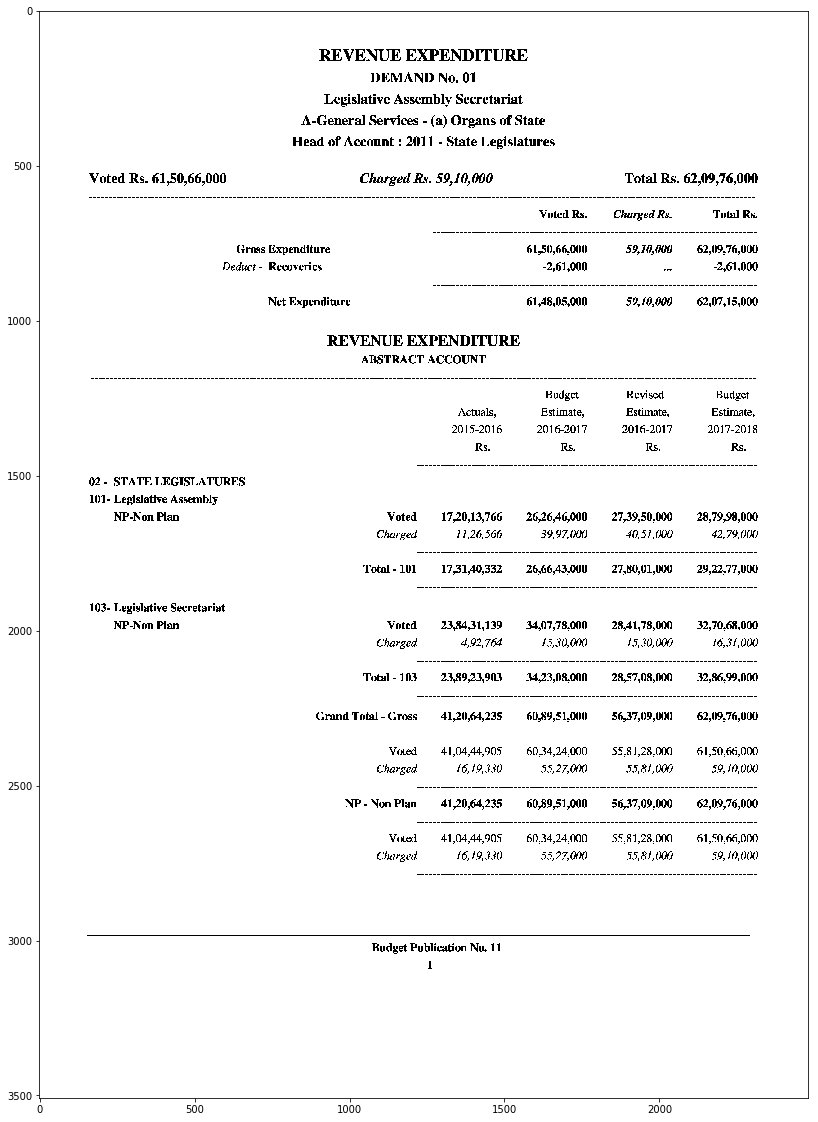

In [7]:
plt.figure(figsize=(30,20))
plt.imshow(img_page2, cmap='gray')

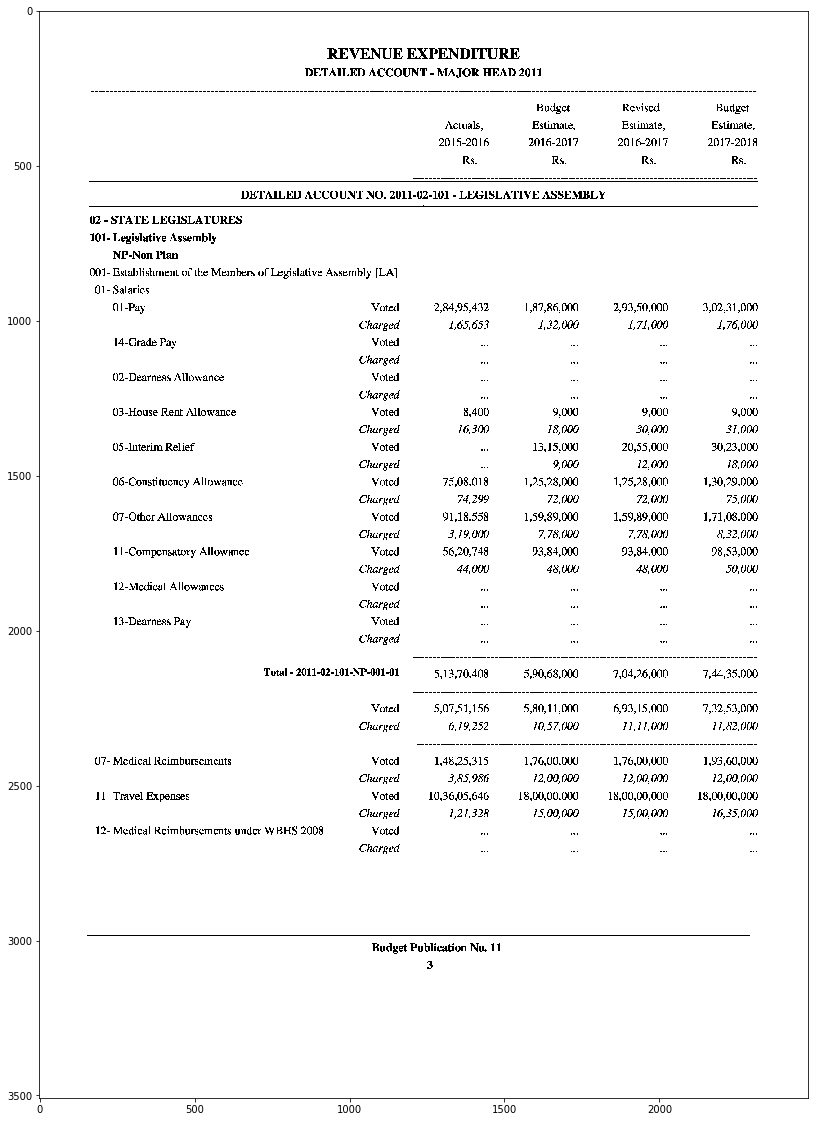

In [8]:
plt.figure(figsize=(30,20))
plt.imshow(img_page4, cmap='gray')

### RLSA Implementation

http://crblpocr.blogspot.in/2007/06/run-length-smoothing-algorithm-rlsa.html

The Run Length Smoothing Algorithm (RLSA) is a method that can be used for Block segmentation and text discrimination. The method developed for the Document Analysis System consists of two steps. First, a segmentation procedure subdivides the area of a document into regions (blocks), each of which should contain only one type of data (text, graphic, halftone image, etc.). Next, some basic features of these blocks are calculated.

The basic RLSA is applied to a binary sequence in which white pixels are represented by 0’s and black pixels by 1’s. The algorithm transforms a binary sequence x into an output sequence y according to the following rules:

1. 0’s in x are changed to 1’s in y if the number of adjacent 0’s is less than or equal to a predefined limit C.
2. 1’s in x are unchanged in y .

For example, with C = 4 the sequence x is mapped into y as follows:

x : 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0      
y : 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1


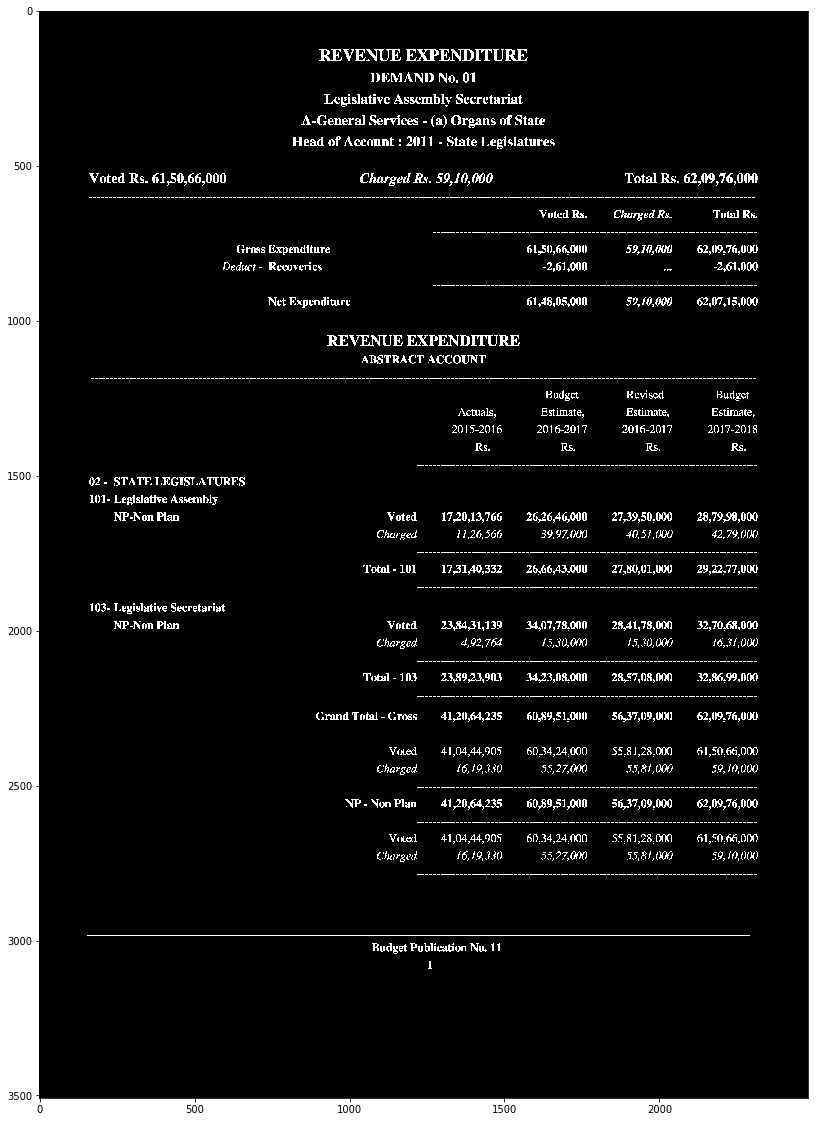

In [9]:
ret,thresh1 = cv2.threshold(img_page2,0,1,cv2.THRESH_BINARY_INV)
plt.figure(figsize=(30,20))
plt.imshow(thresh1, cmap='gray')

In [10]:
def rlsa(img, threshold):
    ret,thresh1 = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY_INV)
    img_iter = np.nditer(thresh1, flags=['multi_index'])
    C_vertical, C_horizontal = threshold
    temp_thresh = thresh1.copy()
    while not img_iter.finished:
        x, y = img_iter.multi_index
        x_threshold = x + C_horizontal
        y_threshold = y + C_vertical
        neg_x_threshold = x - C_horizontal
        neg_y_threshold = y - C_vertical
        if (thresh1[x:x_threshold, y:y_threshold].any() 
            or thresh1[x:x_threshold, y:neg_y_threshold].any()
            or thresh1[x:neg_x_threshold, y:y_threshold].any()
            or thresh1[x:neg_x_threshold, y:neg_y_threshold].any()):
            temp_thresh[x, y] = 1
        else:
            temp_thresh[x, y] = 0
        img_iter.iternext()
    return temp_thresh

def plot_page(img):
    plt.figure(figsize=(30,20))
    plt.imshow(img, cmap='gray')

In [11]:
img_page4_rlsa = rlsa(img_page4, (15, 25))

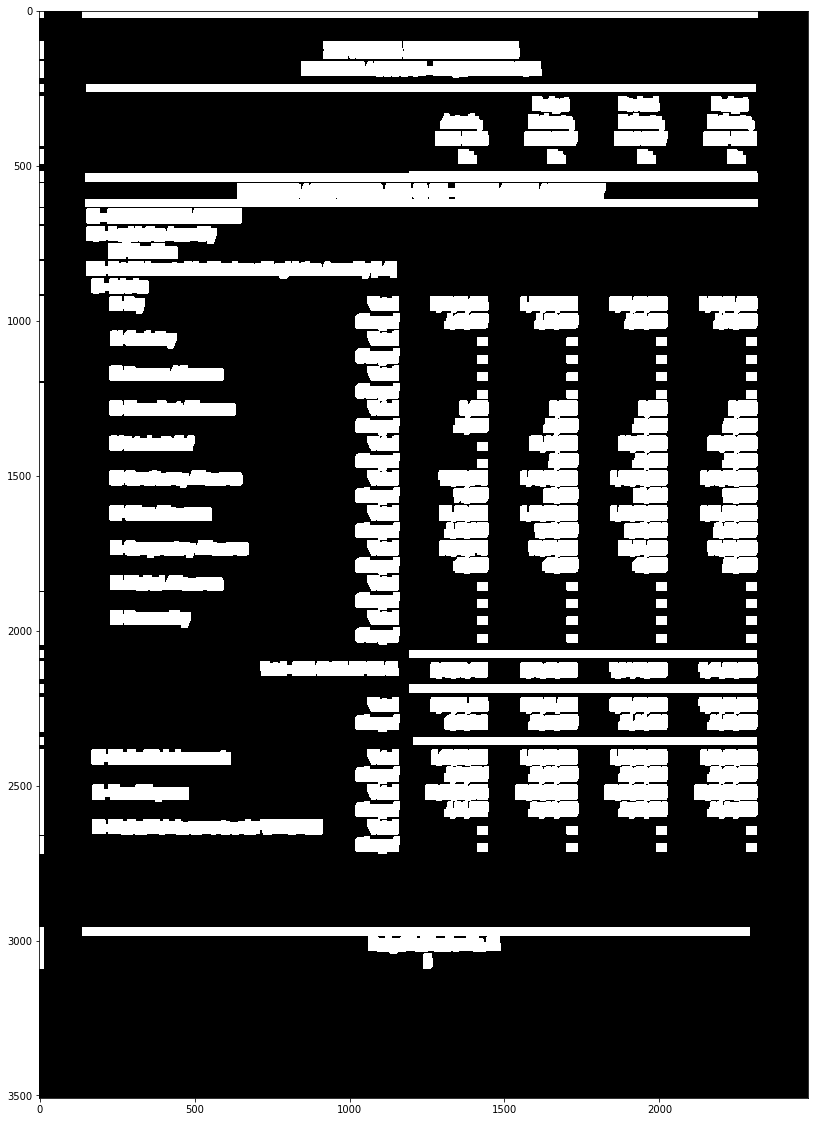

In [12]:
plot_page(img_page4_rlsa)

In [13]:
n_comp, labels, stats, centroids = cv2.connectedComponentsWithStats(img_page4_rlsa)

In [14]:
n_comp

167

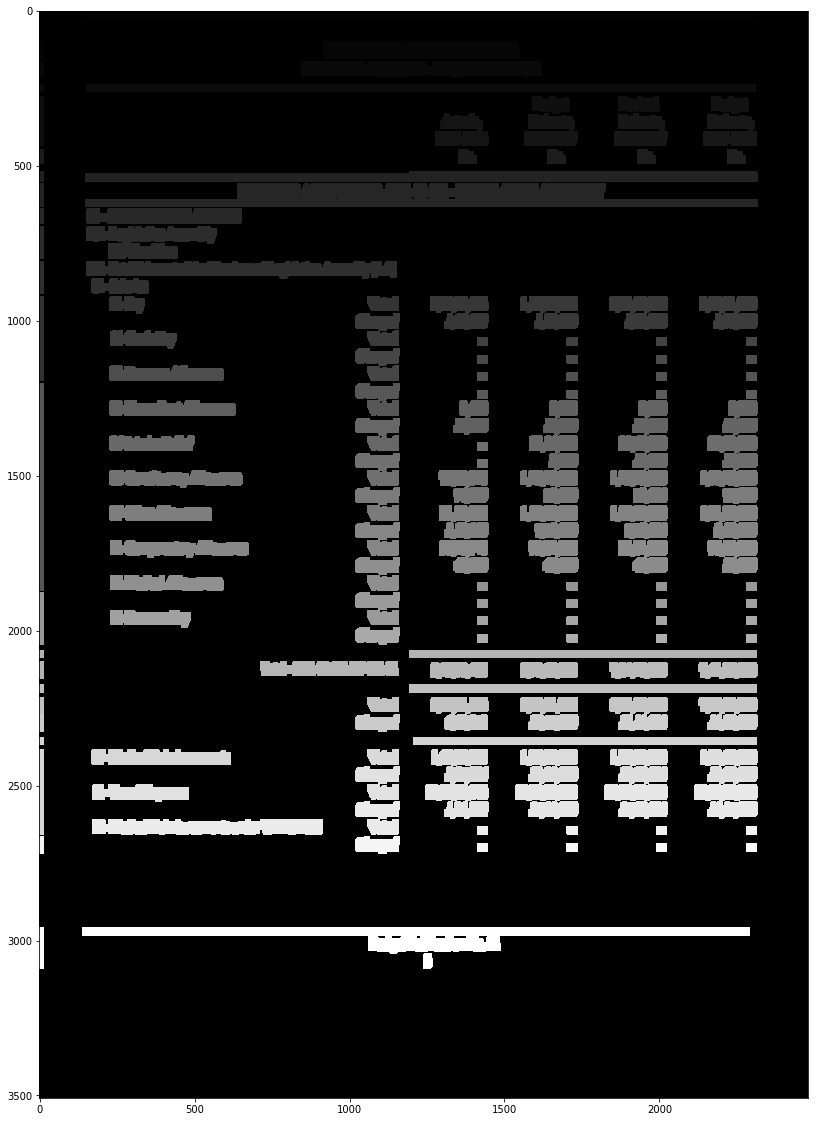

In [15]:
plot_page(labels)

Stats definitions http://docs.opencv.org/trunk/d3/dc0/group__imgproc__shape.html#gac7099124c0390051c6970a987e7dc5c5

In [16]:
stats_columns = ["left", "top", "width", "height", "area"]
label_stats = pd.DataFrame(stats, columns=stats_columns)
label_stats['centroid_x'], label_stats['centroid_y'] = centroids[:, 0], centroids[:, 1]
# Ignore the label 0 since it is the background
label_stats.drop(0, inplace=True)

In [17]:
label_stats.head()

,left,top,width,height,area,centroid_x,centroid_y
1,0,0,15,25,375,7.000000,12.000000
2,140,0,2178,25,54450,1228.500000,12.000000
3,0,100,15,59,885,7.000000,129.000000
4,916,100,633,59,36608,1232.050016,128.580064
5,0,164,15,54,810,7.000000,190.500000


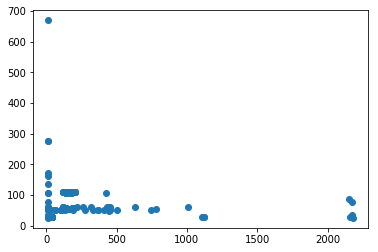

In [18]:
plt.scatter(label_stats.width, label_stats.height)

In [19]:
label_stats.top.sort_index(ascending=False)

166    3041
165    2957
164    2957
163    2686
162    2686
161    2686
160    2686
159    2664
158    2664
157    2630
156    2630
155    2630
154    2630
153    2608
152    2552
151    2496
150    2496
149    2496
148    2496
147    2496
146    2439
145    2383
144    2383
143    2383
142    2383
141    2383
140    2383
139    2383
138    2343
137    2343
       ... 
30      808
29      696
28      696
27      639
26      639
25      558
24      558
23      518
22      518
21      447
20      447
19      447
18      447
17      447
16      333
15      333
14      333
13      333
12      277
11      277
10      277
9       277
8       237
7       237
6       164
5       164
4       100
3       100
2         0
1         0
Name: top, Length: 166, dtype: int32

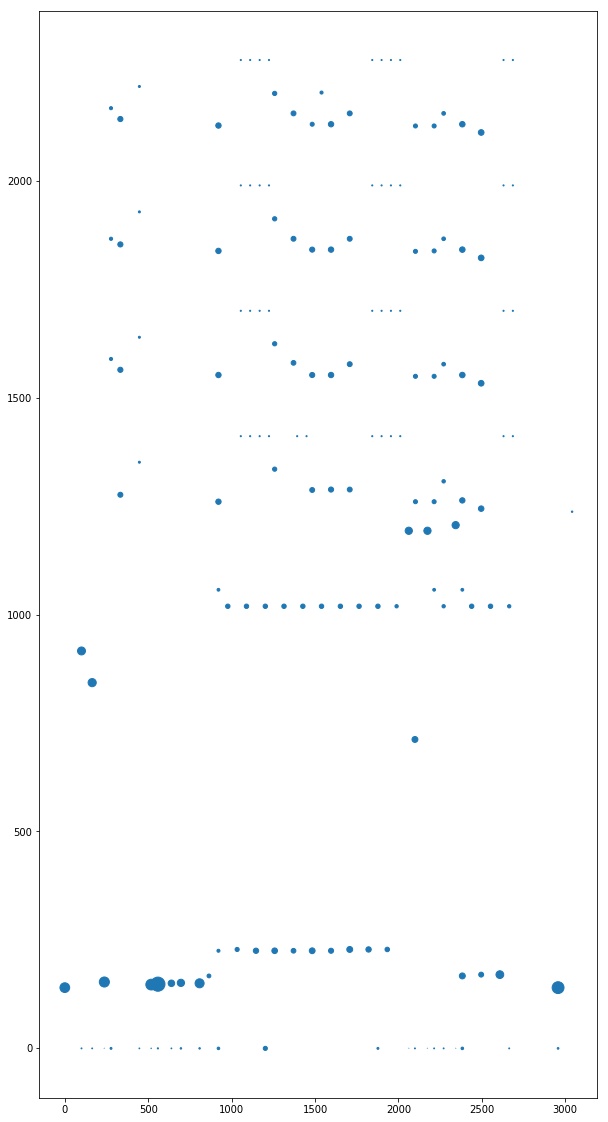

In [20]:
min_max_scaler = preprocessing.MinMaxScaler()
plt.figure(figsize=(10,20))
plt.scatter(label_stats.top, label_stats.left, s=min_max_scaler.fit_transform(label_stats.area) * 200)

In [21]:
label_stats[label_stats.top < 500]

,left,top,width,height,area,centroid_x,centroid_y
1,0,0,15,25,375,7.000000,12.000000
2,140,0,2178,25,54450,1228.500000,12.000000
3,0,100,15,59,885,7.000000,129.000000
4,916,100,633,59,36608,1232.050016,128.580064
5,0,164,15,54,810,7.000000,190.500000
6,843,164,778,54,38447,1230.804276,188.837309
7,0,237,15,27,405,7.000000,250.000000
8,153,237,2158,27,58266,1231.500000,250.000000
9,0,277,15,163,2445,7.000000,358.000000
10,1589,277,123,59,5898,1649.495083,304.985419


In [22]:
label_stats.iloc[36:46]

,left,top,width,height,area,centroid_x,centroid_y
37,1552,921,188,111,16703,1655.143627,970.823026
38,1838,921,191,111,16931,1942.726478,970.544563
39,2127,921,191,111,16948,2231.533455,970.772481
40,1019,977,144,107,11462,1098.317222,1027.419037
41,228,1033,216,59,10137,334.728322,1059.755845
42,1411,1055,38,29,1099,1429.516833,1068.987261
43,1700,1055,38,29,1099,1718.516833,1068.987261
44,1989,1055,37,29,1070,2007.016822,1068.986916
45,2278,1055,37,29,1070,2296.016822,1068.986916
46,1019,1089,144,108,11463,1098.317107,1139.835471


In [23]:
centroids[36:46]

array([[ 1364.20007162,   970.59466396],
       [ 1655.14362689,   970.8230258 ],
       [ 1942.72647806,   970.54456323],
       [ 2231.53345527,   970.77248053],
       [ 1098.31722213,  1027.41903682],
       [  334.72832199,  1059.75584492],
       [ 1429.51683348,  1068.98726115],
       [ 1718.51683348,  1068.98726115],
       [ 2007.01682243,  1068.98691589],
       [ 2296.01682243,  1068.98691589]])

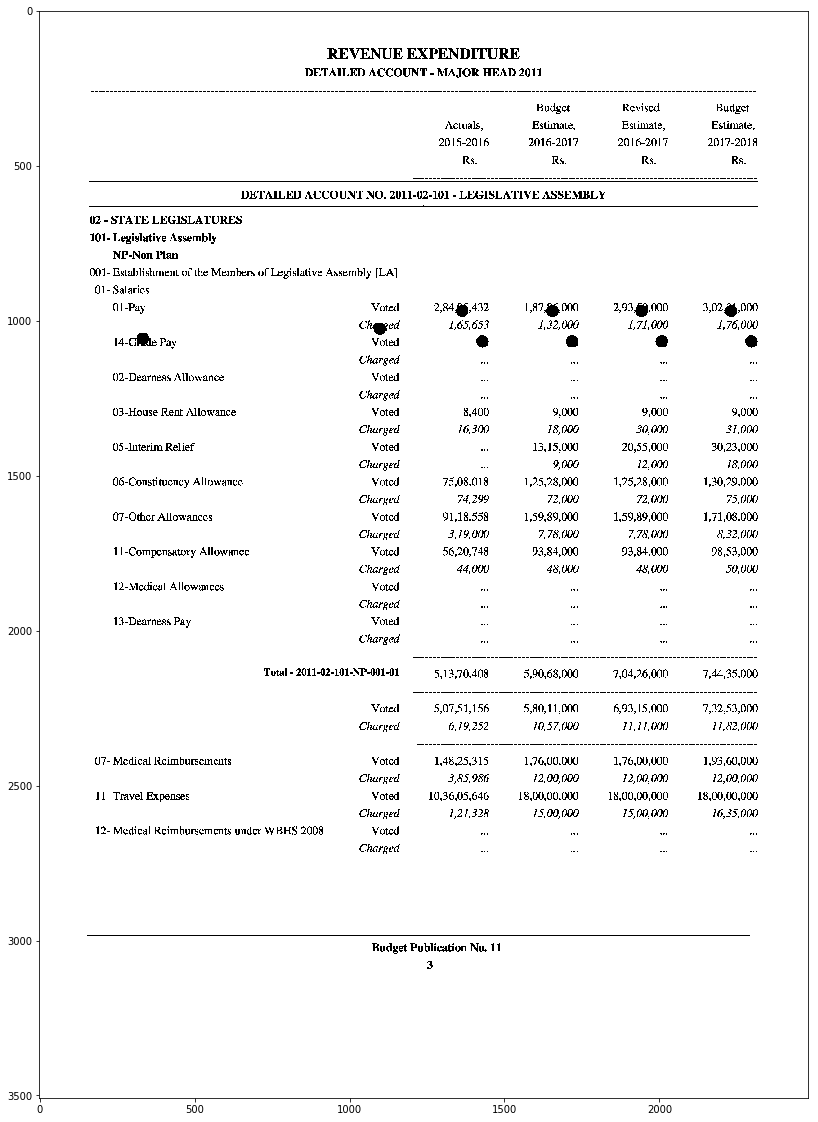

In [24]:
waste_copy = img_page4.copy()
for centroid in centroids[36:46]:
    x, y = centroid
    cv2.circle(waste_copy, (int(x), int(y)), 20, (0,0,255), -1)
plot_page(waste_copy)

In [25]:
label_stats['top_str'] = label_stats.top.apply(lambda x: str(x))

In [26]:
count_top = label_stats.groupby('top_str')['left'].count()
count_top[count_top == 5]

top_str
1258    5
1483    5
1596    5
1708    5
2496    5
447     5
Name: left, dtype: int64

In [27]:
grouped_top = label_stats.groupby('top_str').apply(lambda x: x.iloc[0:10]).sort_values('top')
grouped_top[grouped_top.top_str == '1258']

left   top  width  height   area   centroid_x   centroid_y top_str
top_str                                                                       
1258    65  1912  1258    117     111  10758  1974.298661  1313.873861    1258
        64  1624  1258    116     111  10617  1686.041066  1313.745879    1258
        63  1335  1258    116     111  10506  1397.271274  1314.158862    1258
        66  2201  1258    117     111  10741  2263.345126  1313.779350    1258
        62   225  1258    410      51  18614   425.245568  1285.120071    1258

In [28]:
(label_stats.left - (label_stats.width // 2) ).iloc[12:16].tolist()

[1189, 1477, 1766, 2055]

In [29]:
(label_stats.left + label_stats.width + 10 ).iloc[12:16].tolist()

[1460, 1748, 2037, 2326]

In [30]:
(label_stats.left + label_stats.width + 10)[61:66].tolist()

[645, 1461, 1750, 2039, 2328]

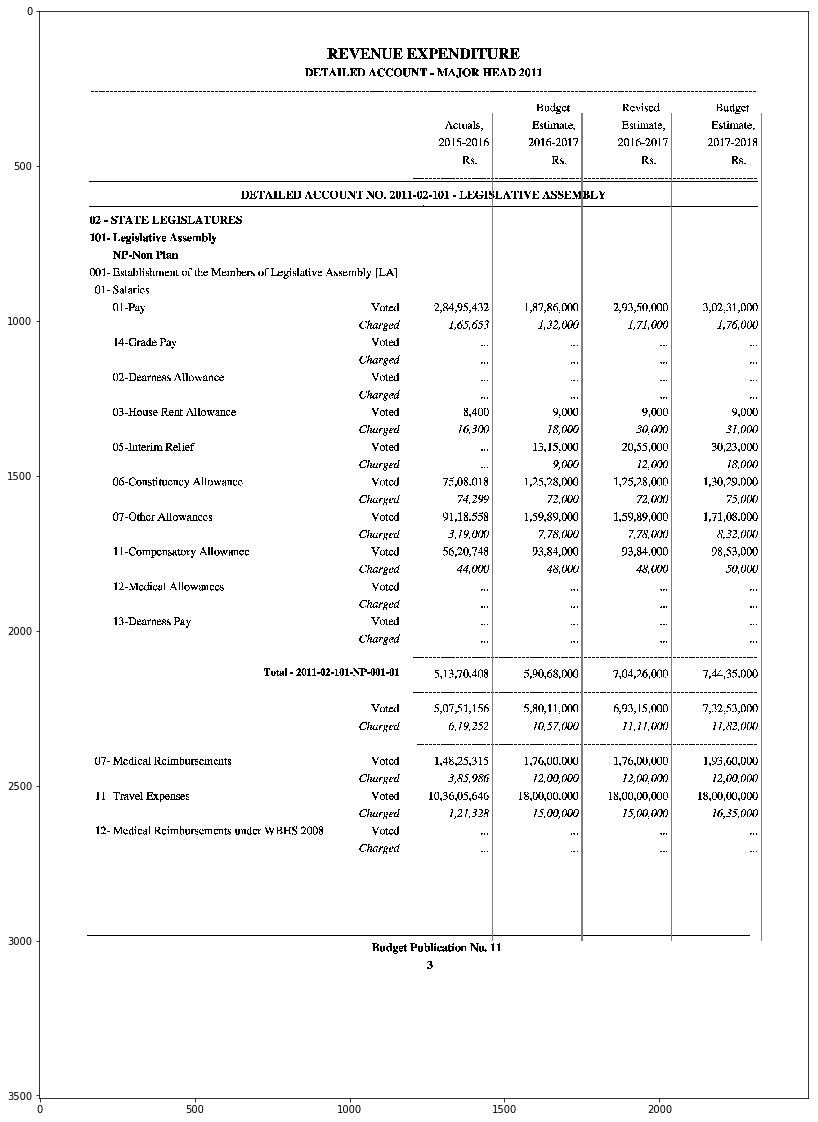

In [31]:
# draw lines at 1411, 1700, 1989, 2278
# left - width [1102, 1390, 1679, 1968]
# left - width / 2 [1189, 1477, 1766, 2055]

def plot_lines(line_xs, img, y_start, y_end):
    waste_copy2 = img.copy()
    for line_x in line_xs:
        line_starting_points = (line_x, y_start)
        line_stopping_points = (line_x, y_end)
        cv2.line(waste_copy2, line_starting_points, line_stopping_points, (125,255,0), 3)
    plot_page(waste_copy2)

plot_lines([1461, 1750, 2039, 2328], img_page4, 333, 3000)

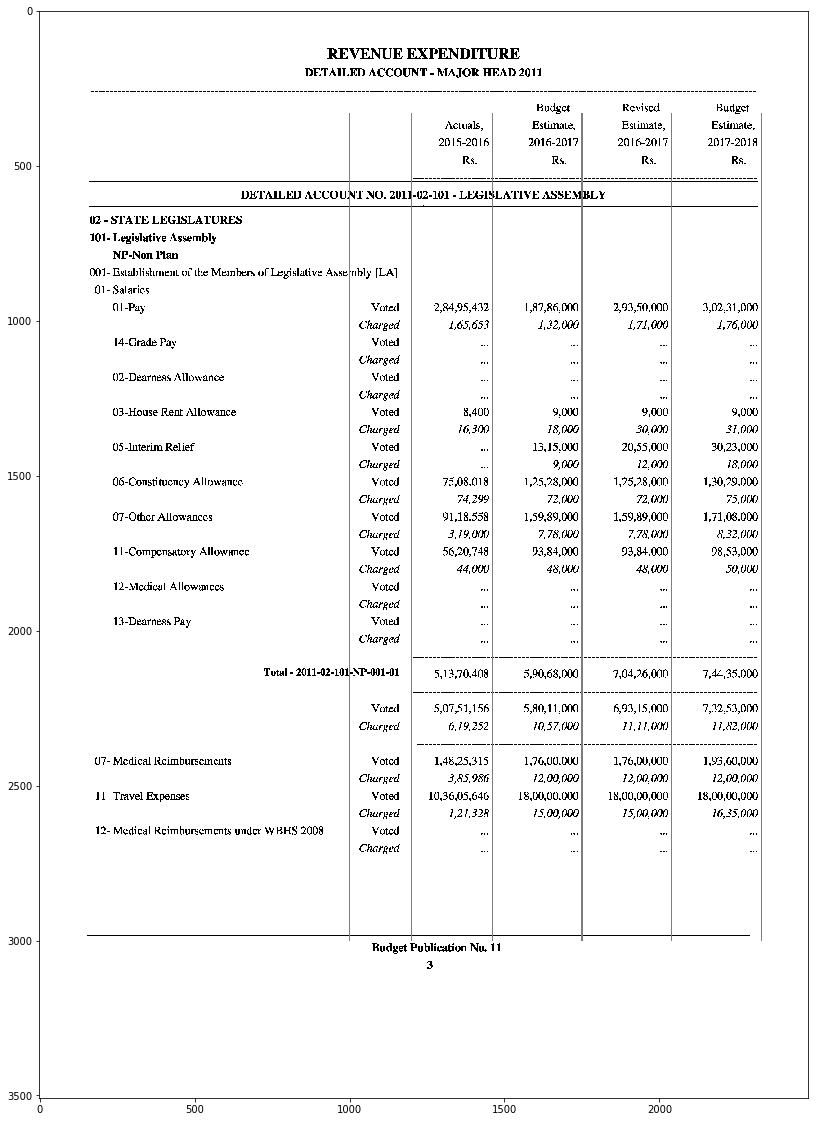

In [32]:
plot_lines([1000,1200,1461, 1750, 2039, 2328], img_page4, 333, 3000)

## Try the same for page 2


In [33]:
rlsa_page2 = rlsa(img_page2, (20, 25))
n_comp, labels, stats, centroids = cv2.connectedComponentsWithStats(rlsa_page2)

In [34]:
def get_label_stats(stats, centroids):
    stats_columns = ["left", "top", "width", "height", "area"]
    label_stats = pd.DataFrame(stats, columns=stats_columns)
    label_stats['centroid_x'], label_stats['centroid_y'] = centroids[:, 0], centroids[:, 1]
    # Ignore the label 0 since it is the background
    label_stats.drop(0, inplace=True)
    return label_stats

page2_label_stats = get_label_stats(stats, centroids)

In [35]:
page2_label_stats['top_str'] = page2_label_stats.top.apply(lambda x: str(x))
page2_label_stats.groupby('top_str').apply(lambda x: x.iloc[0:10]).sort_values('top')

left   top  width  height   area   centroid_x   centroid_y  \
top_str                                                                   
0       1       0     0     20      25    500     9.500000    12.000000   
        2     135     0   2183      25  54575  1226.000000    12.000000   
103     4     885   103    690      62  42076  1229.127793   133.112392   
        3       0   103     20      62   1240     9.500000   133.500000   
177     6    1049   177    360      57  19420  1225.853708   205.540783   
        5       0   177     20      57   1140     9.500000   205.000000   
246     7       0   246     20      66   1320     9.500000   278.500000   
        8     901   246    658      66  34215  1225.751308   277.009908   
315     9       0   315     20      66   1320     9.500000   347.500000   
        10    827   315    805      66  41069  1232.540627   346.063040   
383     11      0   383     20      66   1320     9.500000   415.500000   
        12    798   383    864      66  44366  1228.446445   413.491277   
502     13      0   502     20      66   1320     9.500000   534.500000   
        14    142   502    462      65  25409   379.711559   531.492739   
        15   1016   502    446      66  24421  1242.827566   532.310348   
        16   1869   502    448      65  24894  2098.311762   531.411304   
580     17      0   580     20      27    540     9.500000   593.000000   
        18    143   580   2164      27  58428  1224.500000   593.000000   
620     19      0   620     20      59   1180     9.500000   649.000000   
        20   1833   620    206      59   9843  1933.956416   648.331505   
621     21   1593   621    174      51   8152  1678.513494   646.764475   
        22   2154   621    162      51   7692  2232.769501   646.766381   
693     24   1251   693   1065      27  28755  1783.000000   706.000000   
        23      0   693     20      27    540     9.500000   706.000000   
733     25      0   733     20     113   2260     9.500000   789.000000   
        26    618   733    320      58  14864   775.951023   760.459634   
        27   1553   733    214     113  19317  1671.421235   782.727390   
        28   1873   733    169      57   8747  1957.048588   759.089859   
        29   2103   733    214     113  19346  2221.338261   782.709604   
789     30    570   789    149      51   6448   640.050093   816.051489   
...           ...   ...    ...     ...    ...          ...          ...   
2312    109  1201  2312   1115      27  30105  1758.000000  2325.000000   
2352    110     0  2352     20     114   2280     9.500000  2408.500000   
        111  1108  2352    110      51   5085  1163.480826  2377.670403   
        112  1277  2352    216     111  19416  1395.550783  2402.243871   
        113  1553  2352    215     111  19639  1669.992158  2402.199145   
        114  1828  2352    215     111  19683  1944.925926  2402.218107   
        115  2103  2352    215     111  19667  2220.060558  2402.283216   
2408    116  1070  2408    149      58   7042  1143.765124  2435.896904   
2480    118  1201  2480   1115      27  30105  1758.000000  2493.000000   
        117     0  2480     20      27    540     9.500000  2493.000000   
2521    119     0  2521     20      57   1140     9.500000  2549.000000   
        123  1827  2521    215      57  11284  1933.903314  2547.162708   
        120   969  2521    249      51  11604  1090.725009  2546.832644   
        121  1277  2521    215      57  11140  1384.866876  2547.031688   
        122  1553  2521    214      57  11232  1659.334046  2547.156428   
        124  2103  2521    214      57  11232  2209.386485  2547.143162   
2593    125     0  2593     20      27    540     9.500000  2606.000000   
        126  1201  2593   1115      27  30105  1758.000000  2606.000000   
2633    132  2103  2633    215     111  19667  2220.060558  2683.283216   
        131  1828  2633    215     111  19683  1944.925926  2683.218107   
        130  1553  2633    215     111

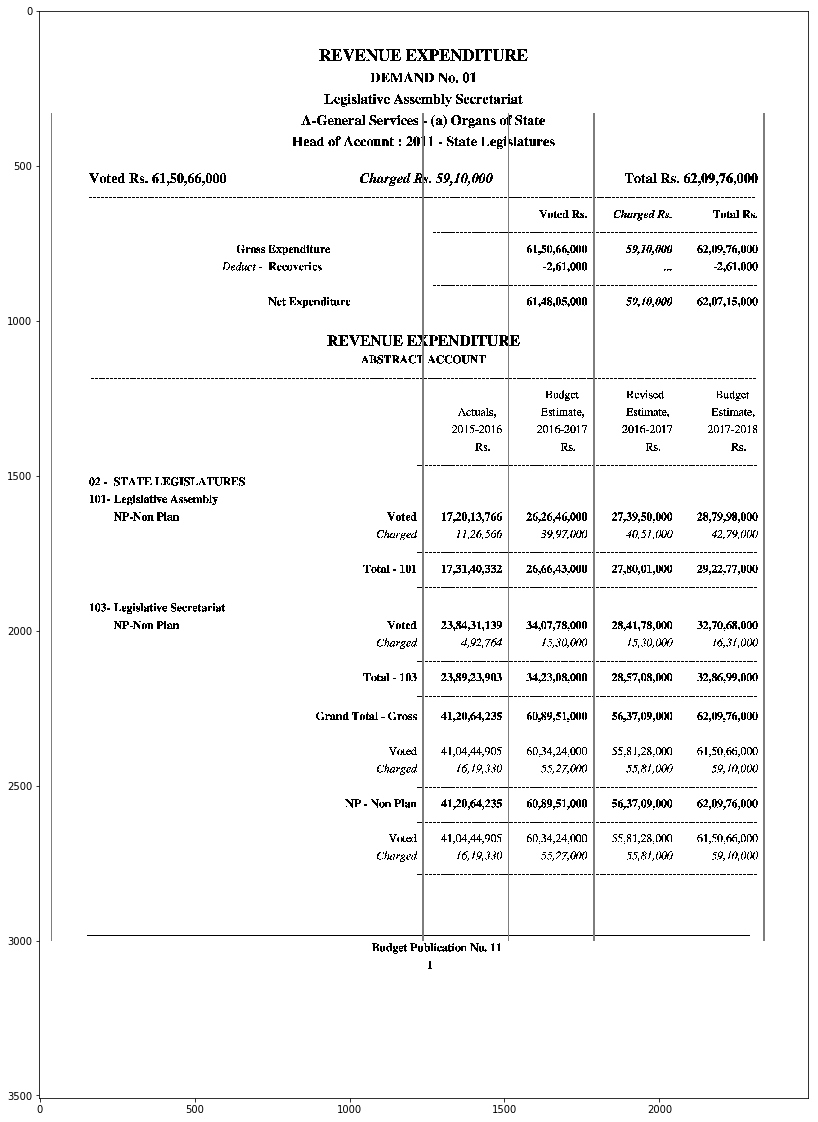

In [36]:
line_xs = (page2_label_stats.left + page2_label_stats.width + 20).iloc[125:130].tolist()
plot_lines(line_xs, img_page2, 333, 3000)

In [37]:
line_xs

[2336, 40, 1238, 1513, 1788]

## Column Detection

Need to figure out column selection that would work on both with and without columnar lines.

### Thouhgts/Ideas

`Left - Width` will not work as it varies with document pages and needs to be adjusted.     
`Left + Width + Buffer` works :D. Since its numbers

## TODO

- Table Boundaries
- Row Boundaries
- Table Headers

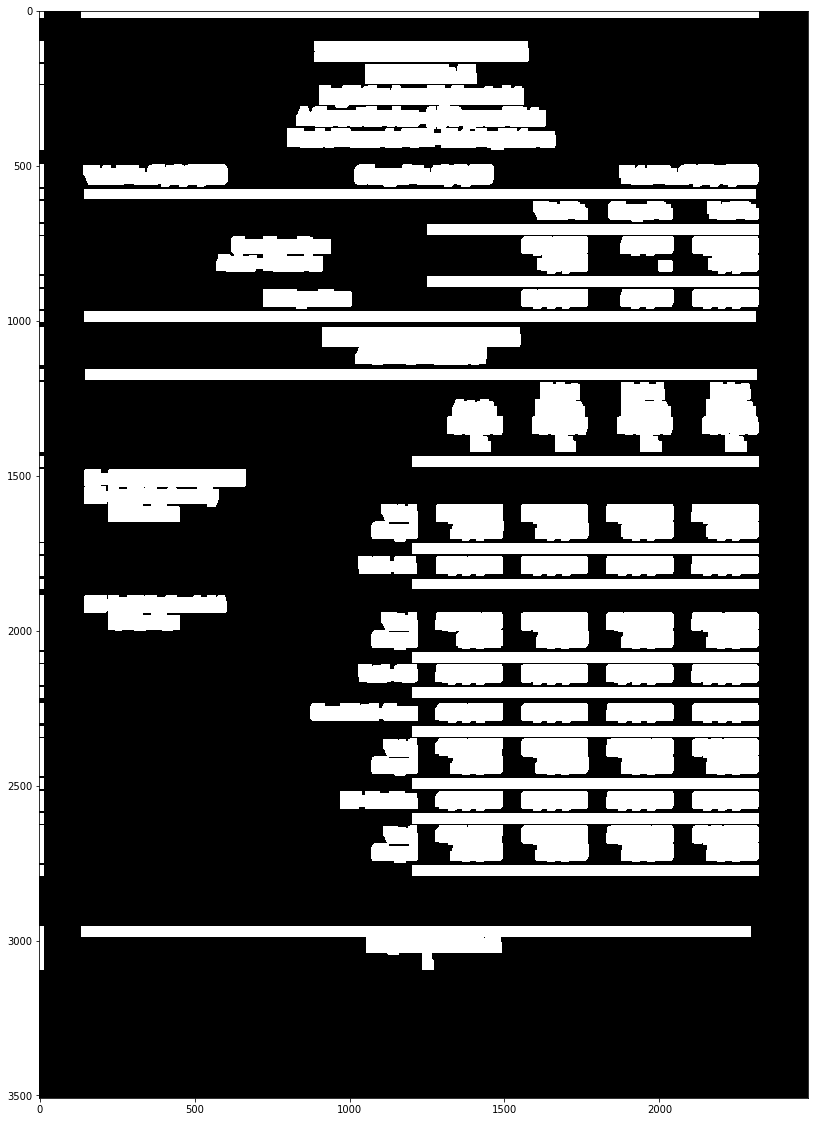

In [38]:
eroded_image = cv2.erode(img_page2, kernel = np.ones((5,5),np.uint8), iterations=2)
rlsa_eroded_image = rlsa(eroded_image, (15, 25))
plot_page(rlsa_eroded_image)

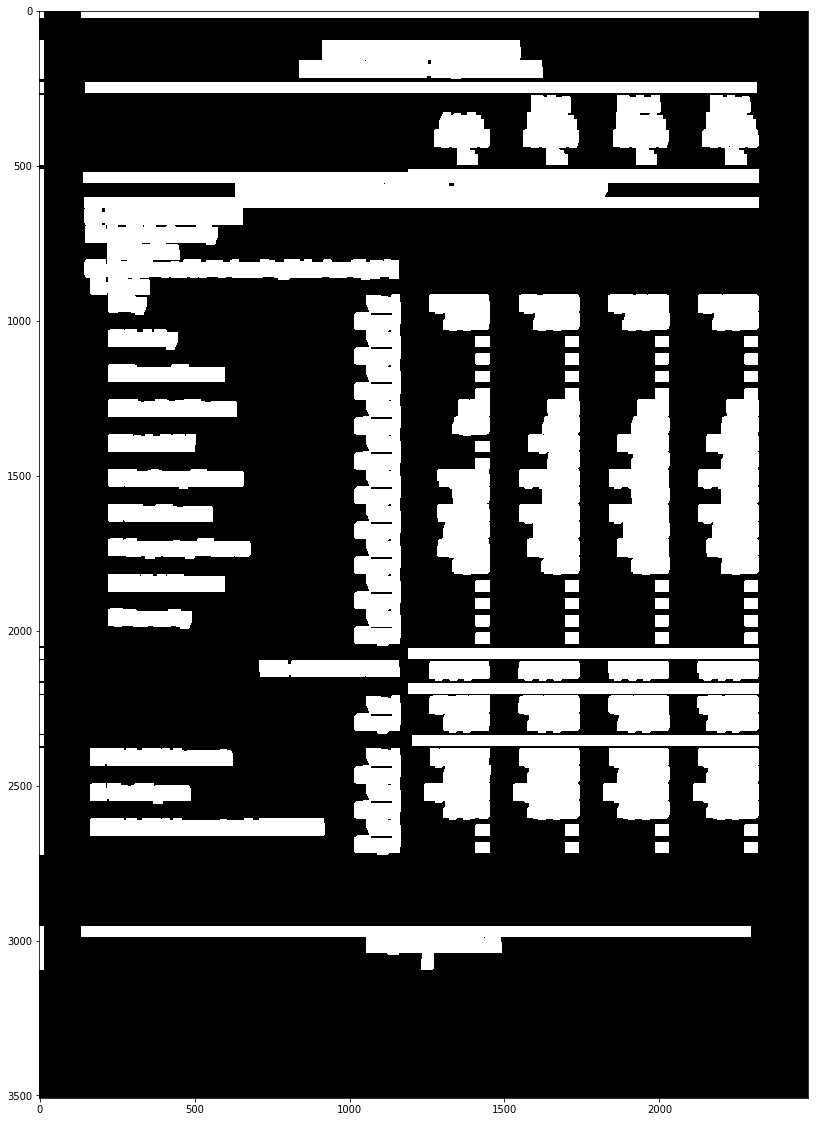

In [39]:
eroded_image_page4 = cv2.erode(img_page4, kernel = np.ones((5,5),np.uint8), iterations=2)
rlsa_eroded_image_page4 = rlsa(eroded_image_page4, (15, 25))
plot_page(rlsa_eroded_image_page4)

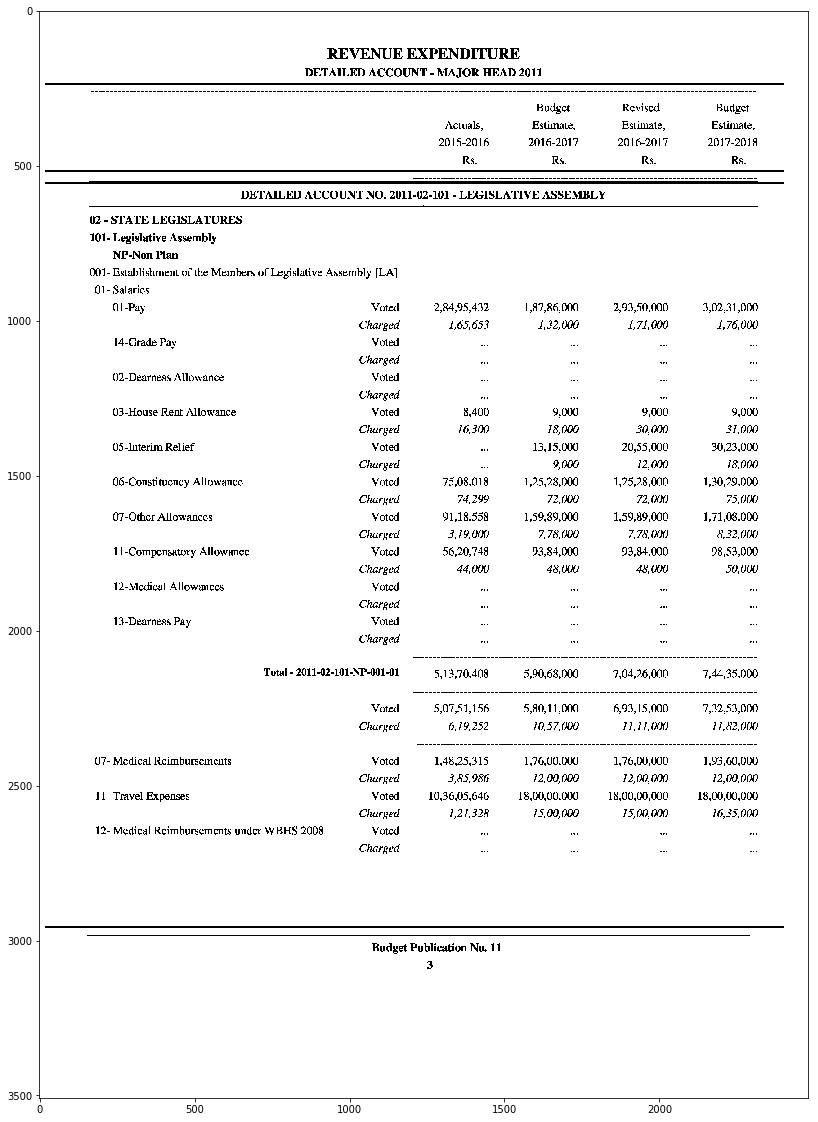

In [40]:
waste_copy = img_page4.copy()
for index, row in label_stats[(label_stats.width > 1250) & (label_stats.top > 0)].iterrows():
    cv2.line(waste_copy, (20, row['top']), (2400, row['top']), (0,255,0), 5)
plot_page(waste_copy)

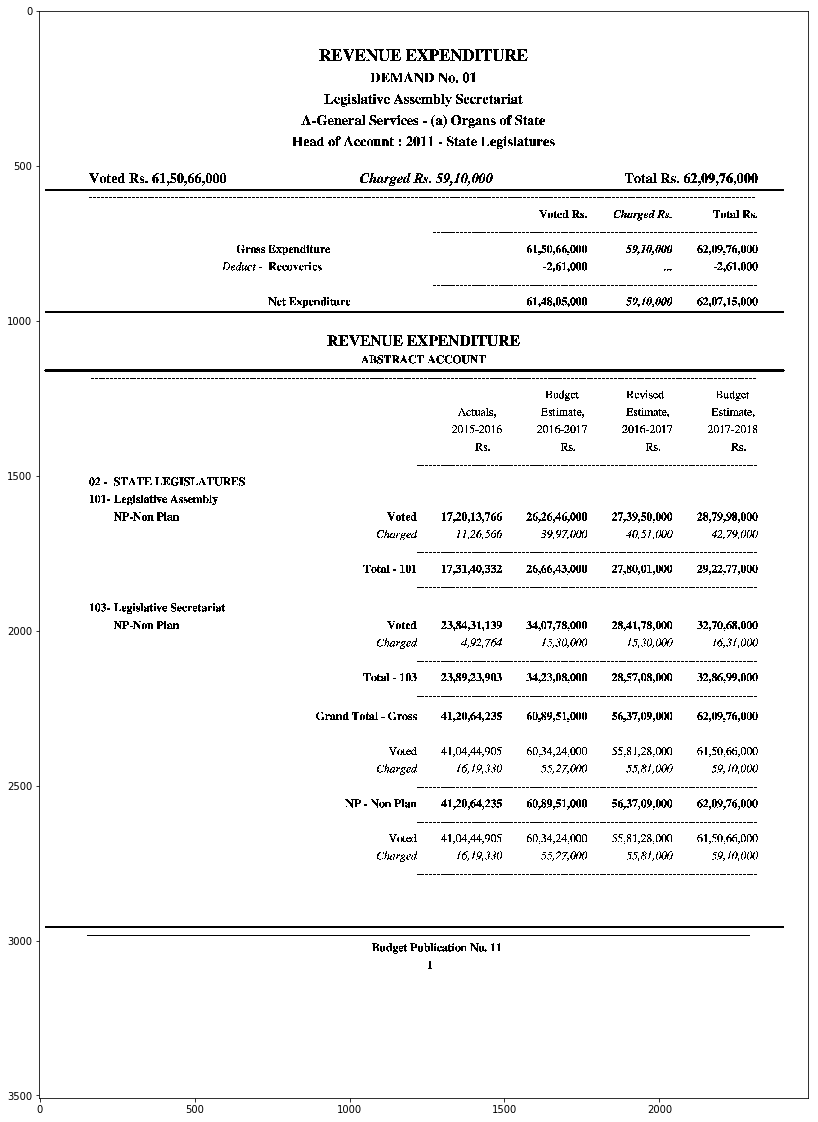

In [41]:
waste_copy = img_page2.copy()
for index, row in page2_label_stats[(page2_label_stats.width > 1200) & (page2_label_stats.top > 0)].iterrows():
    cv2.line(waste_copy, (20, row['top']), (2400, row['top']), (0,255,0), 5)
plot_page(waste_copy)

In [42]:
# the current method
def draw_table_bounds(image_gray):
        table_bounds = None
        temp_image, contours, hierarchy = cv2.findContours(image_gray,
                                                           cv2.RETR_LIST,
                                                           cv2.CHAIN_APPROX_SIMPLE)
        best_match_contour_index = None
        max_contour_size = 0
        count = 0
        for contour in contours:
            if cv2.contourArea(contour) > max_contour_size:
                contour_size = cv2.contourArea(contour)
                x, y, w, h = cv2.boundingRect(contour)
                if x > 0 and y > 0 and contour_size > max_contour_size:
                    best_match_contour_index = count
                    max_contour_size = contour_size
            count += 1
        if best_match_contour_index:
            x, y, w, h = cv2.boundingRect(contours[best_match_contour_index])
            x = x - 10
            w = w + 10
            cv2.rectangle(image_gray, (x, y), (x+w, y+h), (125, 125, 0), 5)
            cv2.rectangle(image_gray, (x, y), (x+w, y+h), (125, 125, 0), 5)
        return image_gray

In [43]:
# plot_page(draw_table_bounds(img_page4))

Detect similarly shaped blocks to merge together. 

How to detect similar blocks ??
    - Vertical
        - Similar left most points
        - Similar right most points
    - Horizontal
        - Similar top most points
        - Similar bottom most points
    - Shorter then the parent or similar width.

In [44]:
page2_label_stats['right'] = page2_label_stats.left + page2_label_stats.width
page2_label_stats['bottom'] = page2_label_stats.top + page2_label_stats.height
label_stats['right'] = label_stats.left + label_stats.width
label_stats['bottom'] = label_stats.top + label_stats.height

In [45]:
page2_label_stats

,left,top,width,height,area,centroid_x,centroid_y,top_str,right,bottom
1,0,0,20,25,500,9.500000,12.000000,0,20,25
2,135,0,2183,25,54575,1226.000000,12.000000,0,2318,25
3,0,103,20,62,1240,9.500000,133.500000,103,20,165
4,885,103,690,62,42076,1229.127793,133.112392,103,1575,165
5,0,177,20,57,1140,9.500000,205.000000,177,20,234
6,1049,177,360,57,19420,1225.853708,205.540783,177,1409,234
7,0,246,20,66,1320,9.500000,278.500000,246,20,312
8,901,246,658,66,34215,1225.751308,277.009908,246,1559,312
9,0,315,20,66,1320,9.500000,347.500000,315,20,381
10,827,315,805,66,41069,1232.540627,346.063040,315,1632,381


In [46]:
label_2_label_map = np.zeros((page2_label_stats.shape[0], page2_label_stats.shape[0]))

In [47]:
label_2_label_map[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [48]:
for index, value in enumerate(label_2_label_map[10]):
    base_label = page2_label_stats.iloc[13]
    print(base_label)
    similarly_aligned = page2_label_stats[(page2_label_stats.top > base_label.top) & 
                                          (page2_label_stats.right.between(base_label.right - 10, base_label.right + 10)) &
                                          (page2_label_stats.width.between(base_label.width - 20, base_label.width + 20))]
    print(similarly_aligned)
    similarly_aligned = similarly_aligned.append(base_label)
    break

left              142
top               502
width             462
height             65
area            25409
centroid_x    379.712
centroid_y    531.493
top_str           502
right             604
bottom            567
Name: 14, dtype: object
    left   top  width  height   area  centroid_x   centroid_y top_str  right  \
85   144  1889    457     108  32860  356.778119  1934.333932    1889    601   

    bottom  
85    1997  


In [49]:
similarly_aligned.index

Int64Index([85, 14], dtype='int64')

In [50]:
page_layout = pdf.getPage(3)['/MediaBox']
if '/Rotate' in pdf.getPage(3) and pdf.getPage(3)['/Rotate'] == 90:
    page_width = float(page_layout[3])
    page_height = float(page_layout[2])
else:
    page_width = float(page_layout[2])
    page_height = float(page_layout[3])

In [51]:
image_height, image_width = img_page2.shape
horizontal_ratio = page_width/image_width
vertical_ratio = page_height/image_height


(34.082291246470355, 120.49144811858609)
(15.601482326111745, 110.8874546187979)
(34.5623235175474, 453.403078677309)
(25.922462941847208, 109.68737394110529)


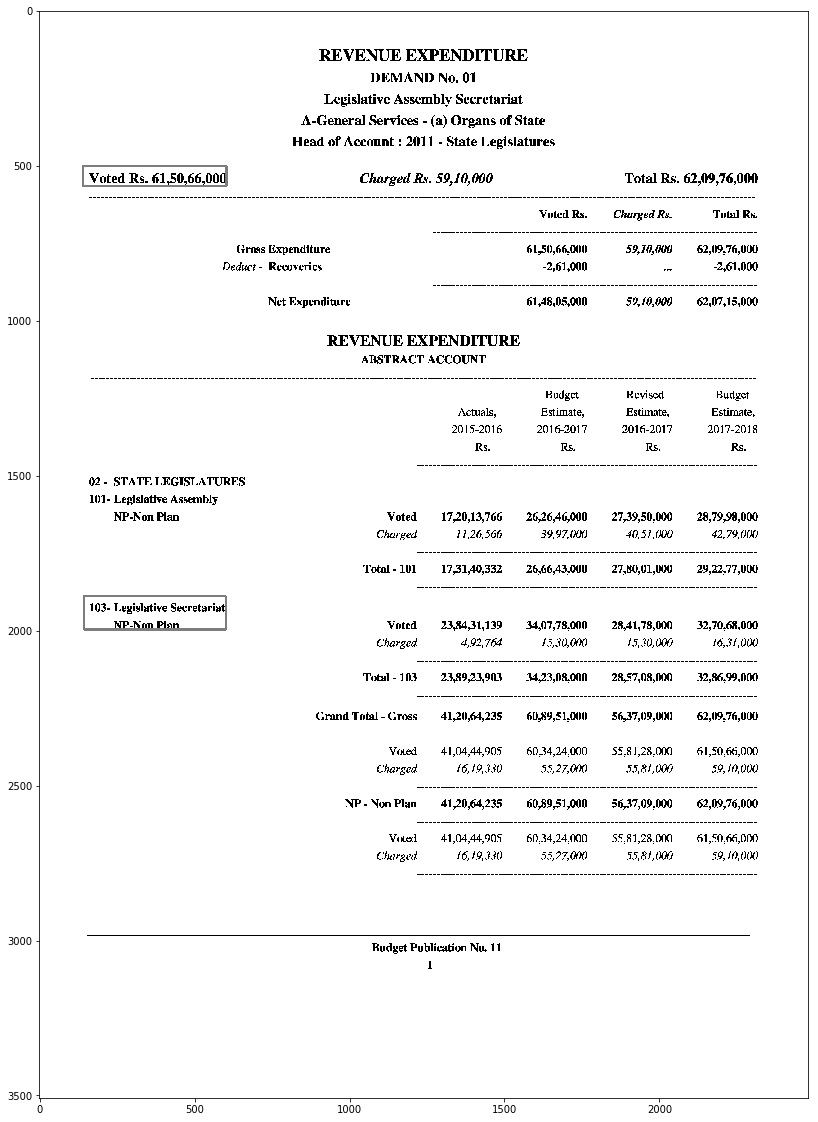

In [52]:
waste_copy = img_page2.copy()
for index, row in page2_label_stats[page2_label_stats.index.isin(similarly_aligned.index)].iterrows():
    print(row.left * horizontal_ratio, row.top * vertical_ratio)
    print(row.height * vertical_ratio, row.width * horizontal_ratio)
    cv2.rectangle(waste_copy, (row['left'], row['top']), (row['right'], row['bottom']), (125,125,0), 5)
plot_page(waste_copy)

In [53]:
def find_similar_blocks(row, label_stats, similarity_map):
    similarly_aligned = label_stats[(label_stats.top > row.top) & 
                                    (label_stats.right.between(row.right - 10, row.right + 10)) &
                                    (label_stats.width.between(row.width - 20, row.width + 20))]
    positions = [[row['pos'] - 1] * len(similarly_aligned), similarly_aligned.index.tolist()]
    similarity_map[positions] = 1
    return None

In [54]:
def add_similarity_map(label_stats):
    similarity_map = np.zeros((label_stats.shape[0], label_stats.shape[0]))
    label_stats.apply(find_similar_blocks, args=[label_stats, similarity_map], axis=1)
    similarity_df = pd.DataFrame(similarity_map, columns=['label_{0}'.format(index) for index in range(label_stats.shape[0])],
                                 index=label_stats.index)
    similarity_df['count'] = similarity_df.apply(sum, axis=1)
    return pd.concat([label_stats, similarity_df], axis=1)

In [55]:
page2_label_stats['pos'] = page2_label_stats.index
similar_labels = add_similarity_map(page2_label_stats)

In [56]:
similar_labels[(similar_labels.left > 0) & (similar_labels['count'] > 1)]

,left,top,width,height,area,centroid_x,centroid_y,top_str,right,bottom,...,label_129,label_130,label_131,label_132,label_133,label_134,label_135,label_136,label_137,count
18,143,580,2164,27,58428,1224.500000,593.000000,580,2307,607,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
20,1833,620,206,59,9843,1933.956416,648.331505,620,2039,679,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
27,1553,733,214,113,19317,1671.421235,782.727390,733,1767,846,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
28,1873,733,169,57,8747,1957.048588,759.089859,733,2042,790,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
29,2103,733,214,113,19346,2221.338261,782.709604,733,2317,846,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9.0
37,1553,902,214,57,11192,1659.620622,928.225965,902,1767,959,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
39,2103,902,214,57,11226,2209.406378,928.139319,902,2317,959,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0
62,1201,1443,1115,27,30105,1758.000000,1456.000000,1443,2316,1470,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0
68,1103,1596,114,51,5405,1160.456614,1621.225532,1596,1217,1647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
69,1279,1596,215,111,19647,1395.623912,1645.971802,1596,1494,1707,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


### From these similar labels we need to figure out structure defining labels

For each parent label remove child label. 

    Maybe use Argmax on the label_x columns to get the indices and then generate the sets.   
    Also ignore the labels with left == 0
    

In [57]:
similar_label_indices = similar_labels[(similar_labels.left > 0) & (similar_labels['count'] > 1)].index.tolist()
parent_label_indices = {}
marked_label_indices = []

In [58]:
# for index in similar_label_indices:
    
    

Sudden Realization, I might not need what I am currently doing for table boudaries and columns!!

Stupendo...

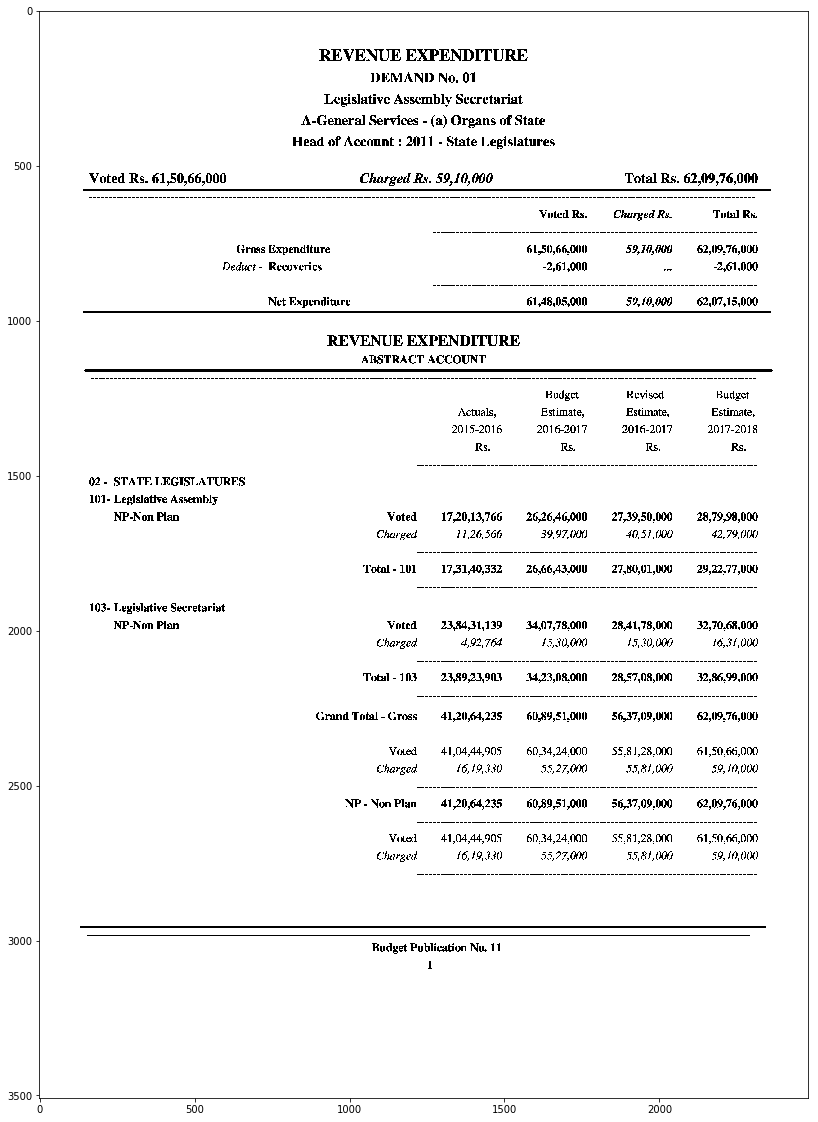

In [59]:
waste_copy = img_page2.copy()
for index, row in page2_label_stats[(page2_label_stats.width > 1200) & (page2_label_stats.top > 0)].iterrows():
    cv2.line(waste_copy, (row['left'], row['top']), (row['right'] + 50, row['top']), (0,255,0), 5)
plot_page(waste_copy)

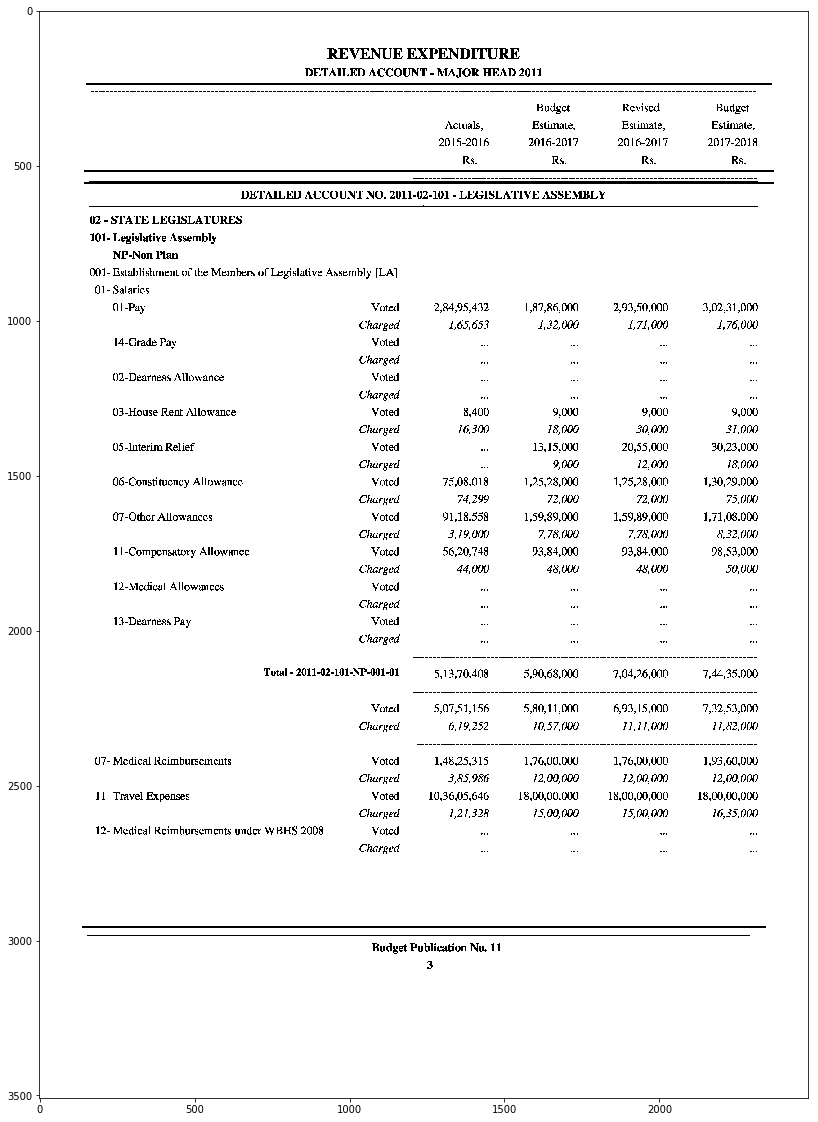

In [60]:
waste_copy = img_page4.copy()
for index, row in label_stats[(label_stats.width > 1200) & (label_stats.top > 0)].iterrows():
    cv2.line(waste_copy, (row['left'], row['top']), (row['left'] + row['width'] + 50, row['top']), (0,255,0), 5)
plot_page(waste_copy)

In the same process remove lines that are in the range of 100 points vertically   
and join the left most and right most points of two independent lines

In [61]:
possible_boundary_lines = page2_label_stats[(page2_label_stats.width > 1200) & (page2_label_stats.top > 0)]
possible_boundary_lines

,left,top,width,height,area,centroid_x,centroid_y,top_str,right,bottom,pos
18,143,580,2164,27,58428,1224.500000,593.000000,580,2307,607,18
41,143,974,2164,27,58428,1224.500000,987.000000,974,2307,1001,41
47,148,1162,2163,27,58401,1229.000000,1175.000000,1162,2311,1189,47
137,135,2957,2157,86,81564,1227.328956,2981.084621,2957,2292,3043,137


In [62]:
possible_boundary_lines['dist_from_next_line'] = possible_boundary_lines.top.shift(-1) - possible_boundary_lines.top
possible_boundary_lines['dist_from_prev_line'] = possible_boundary_lines.top - possible_boundary_lines.top.shift(1)
possible_boundary_lines

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:1]
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:2]


,left,top,width,height,area,centroid_x,centroid_y,top_str,right,bottom,pos,dist_from_next_line,dist_from_prev_line
18,143,580,2164,27,58428,1224.500000,593.000000,580,2307,607,18,394.0,NaN
41,143,974,2164,27,58428,1224.500000,987.000000,974,2307,1001,41,188.0,394.0
47,148,1162,2163,27,58401,1229.000000,1175.000000,1162,2311,1189,47,1795.0,188.0
137,135,2957,2157,86,81564,1227.328956,2981.084621,2957,2292,3043,137,NaN,1795.0


In [63]:
def get_possible_boundary_lines(label_stats):
    possible_boundary_lines = label_stats[(label_stats.width > 1200) & (label_stats.top > 0)]
    possible_boundary_lines['dist_from_next_line'] = possible_boundary_lines.top.shift(-1) - possible_boundary_lines.top
    possible_boundary_lines['dist_from_prev_line'] = possible_boundary_lines.top - possible_boundary_lines.top.shift(1)
    possible_boundary_lines.replace(pd.np.nan, pd.np.inf, inplace=True)
    return possible_boundary_lines[(possible_boundary_lines.dist_from_next_line > 100) & (possible_boundary_lines.dist_from_prev_line > 100)]

In [64]:
get_possible_boundary_lines(page2_label_stats)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:3]
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:4]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:5]


,left,top,width,height,area,centroid_x,centroid_y,top_str,right,bottom,pos,dist_from_next_line,dist_from_prev_line
18,143,580,2164,27,58428,1224.500000,593.000000,580,2307,607,18,394.000000,inf
41,143,974,2164,27,58428,1224.500000,987.000000,974,2307,1001,41,188.000000,394.000000
47,148,1162,2163,27,58401,1229.000000,1175.000000,1162,2311,1189,47,1795.000000,188.000000
137,135,2957,2157,86,81564,1227.328956,2981.084621,2957,2292,3043,137,inf,1795.000000


In [65]:
get_possible_boundary_lines(label_stats)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:3]
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:4]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:5]


,left,top,width,height,area,centroid_x,centroid_y,top_str,right,bottom,dist_from_next_line,dist_from_prev_line
8,153,237,2158,27,58266,1231.500000,250.00000,237,2311,264,281.000000,inf
165,140,2957,2152,86,80811,1229.489475,2980.93809,2957,2292,3043,inf,2399.000000


In [66]:
def draw_table_bounding_box(img, label_stats):
    possible_boundary_lines = get_possible_boundary_lines(label_stats).reset_index()
    waste_copy = img.copy()
    tables = []
    if len(possible_boundary_lines) % 2 != 0:
        raise "Uneven Probable Bounding Lines"
    for index, row in enumerate(possible_boundary_lines.iterrows()):
        if index % 2 != 0:
            table_bounds = {}
            top_bound = possible_boundary_lines.iloc[index - 1]
            bottom_bound = possible_boundary_lines.iloc[index]
            cv2.rectangle(waste_copy, (int(top_bound['left']), int(top_bound['top'])), 
                          (int(bottom_bound['right']) + 50, int(bottom_bound['bottom'])), (125,125,0), 5)
            table_bounds['left'], table_bounds['top'] = int(top_bound['left']), int(top_bound['top'])
            table_bounds['right'], table_bounds['bottom'] = int(bottom_bound['right']) + 50, int(bottom_bound['bottom'])
            tables.append(table_bounds)
    plot_page(waste_copy)
    return tables

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:3]
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:4]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:5]


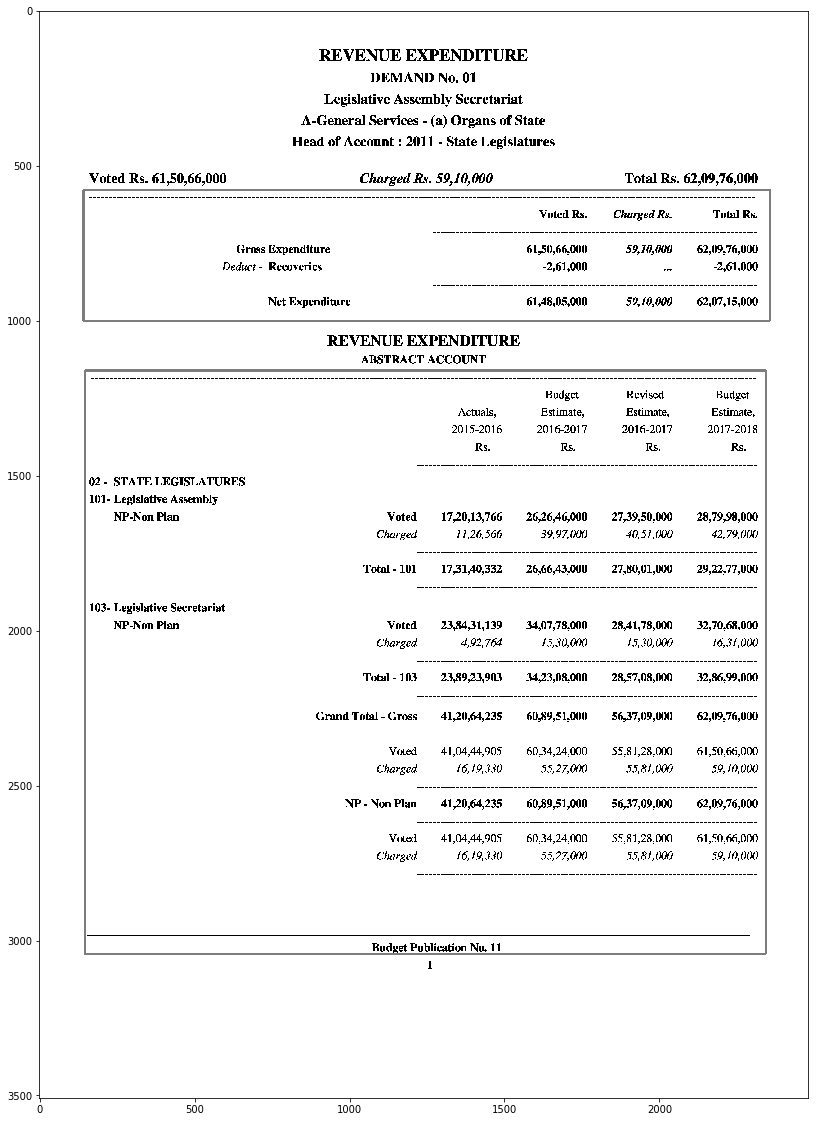

In [67]:
tables = draw_table_bounding_box(img_page2, page2_label_stats)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:3]
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:4]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:5]


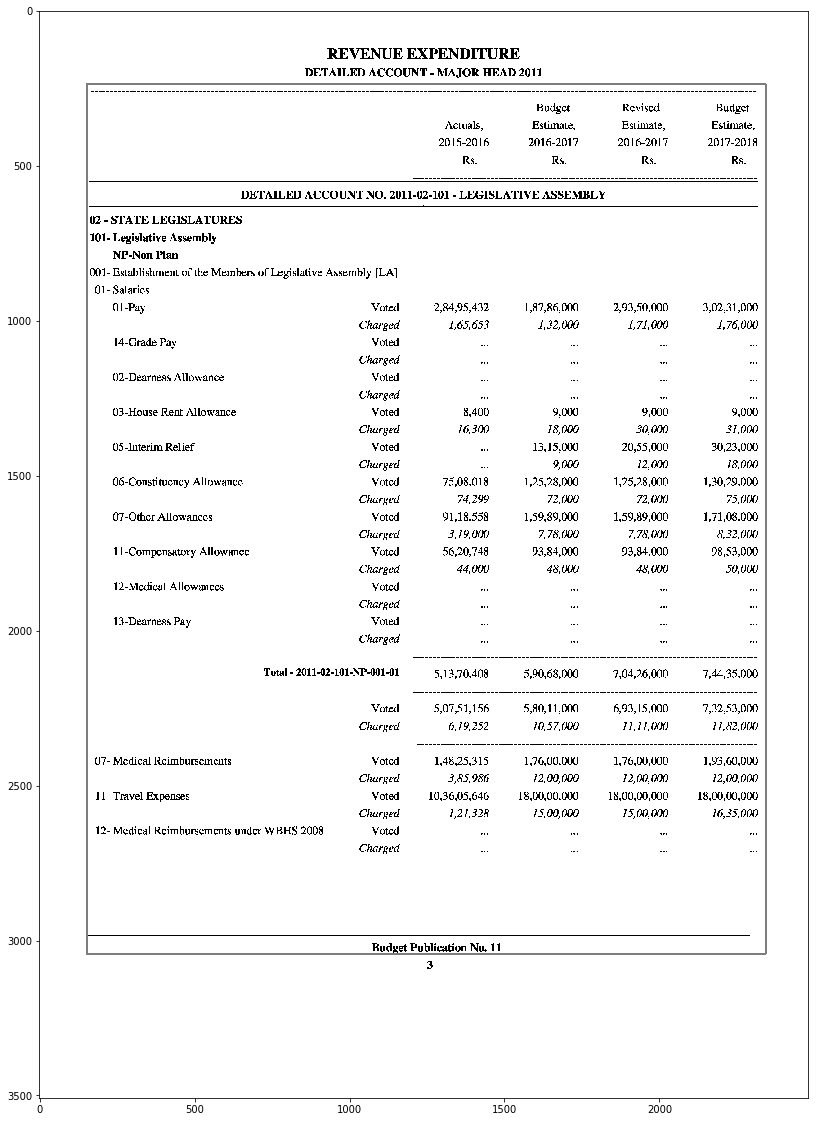

In [68]:
tables = draw_table_bounding_box(img_page4, label_stats)

Now combine the column output and table boundary to send to tabula and check if it works!!

```
java -jar parsers/tabula-0.9.2-jar-with-dependencies.jar --pages %s --area %s,%s,%s,%s --columns %s '%s'" % ( page_num+1, table_bounds["top"], table_bounds["left"], table_bounds["bottom"], table_bounds["right"], column_values, input_pdf_filepath)
```

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:3]
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:4]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:5]


java -jar parsers/tabula-0.9.2-jar-with-dependencies.jar --pages 5 --area 237,153,3043,2342 --columns 237,1000,1200,1461,1750,2039 'parsers/pdfs/West Bengal/2017-18/2017_bp11_Demand Nos.1-5.pdf'


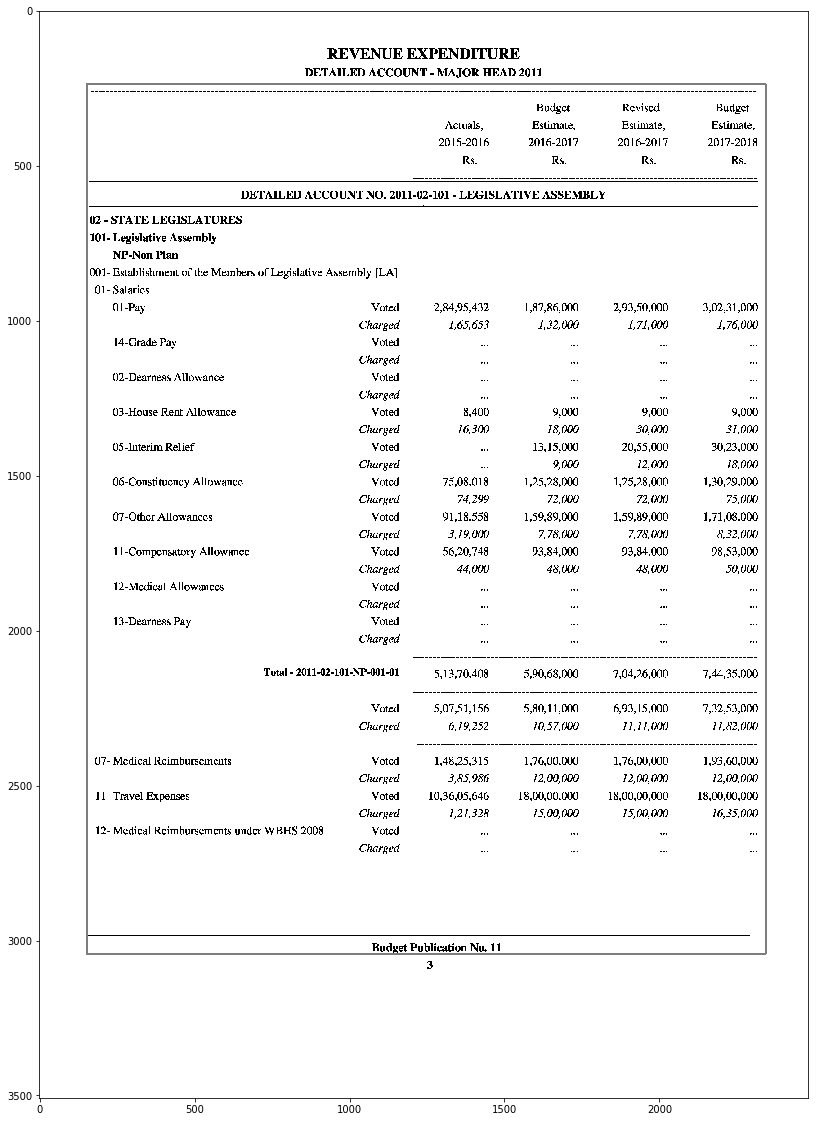

In [69]:
tables = draw_table_bounding_box(img_page4, label_stats)
column_values = ','.join(['237','1000','1200', '1461', '1750', '2039'])
for table_bounds in tables:
    command = "java -jar parsers/tabula-0.9.2-jar-with-dependencies.jar --pages %s --area %s,%s,%s,%s --columns %s '%s'"% ( 5, table_bounds["top"], table_bounds["left"], table_bounds["bottom"], table_bounds["right"], column_values, pdf_file_path)
    print(command)

In [70]:
page_table_data = subprocess.check_output(command, shell=True)

In [71]:
page_table_data.split('\n')

['"","Charged 1,65,653 1,32,000 1,71,000 1,76,000"\r',
 '"",Voted ... ... ... ...\r',
 '"",Charged ... ... ... ...\r',
 '"",Voted ... ... ... ...\r',
 '"",Charged ... ... ... ...\r',
 '"","Voted 8,400 9,000 9,000 9,000"\r',
 '"","Charged 16,300 18,000 30,000 31,000"\r',
 '"","Voted ... 13,15,000 20,55,000 30,23,000"\r',
 '"","Charged ... 9,000 12,000 18,000"\r',
 'e,"Voted 75,08,018 1,25,28,000 1,25,28,000 1,30,29,000"\r',
 '"","Charged 74,299 72,000 72,000 75,000"\r',
 '"","Voted 91,18,558 1,59,89,000 1,59,89,000 1,71,08,000"\r',
 '"","Charged 3,19,000 7,78,000 7,78,000 8,32,000"\r',
 'ce,"Voted 56,20,748 93,84,000 93,84,000 98,53,000"\r',
 '"","Charged 44,000 48,000 48,000 50,000"\r',
 '"",Voted ... ... ... ...\r',
 '"",Charged ... ... ... ...\r',
 '"",Voted ... ... ... ...\r',
 '"",Charged ... ... ... ...\r',
 '"",-----------------------------------------------------------------------------------------\r',
 'Total - 2011-02-101,"-NP-001-01 5,13,70,408 5,90,68,000 7,04,26,000 7,44,35

- Table Bounding Box -- Done
- Columns -- Need Improvement
- Rows -- Not Started

And Tabula isn't giving good results for West Bengal

We are able to get text of blocks using pdftotext from `poppler-0.56.0`

    pdftotext -f 3 -l 3 -x 34 -y 453 -W 110 -H 26 parsers/pdfs/West\ Bengal/2017-18/2017_bp11_Demand\ Nos.1-5.pdf -

x, y, w and h all need to be multiplied with their respective vertical and horizontal ratios for it to work.

Lets explore how we can build rows. 

Also need to figure out a better table bounding box technique. The thought is to figure out how to decide the amount content between 2 given lines. Maybe some kind of measure of content within given 2 lines (Ratio of Sum of black pixels and total pixels)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:3]
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:4]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:5]


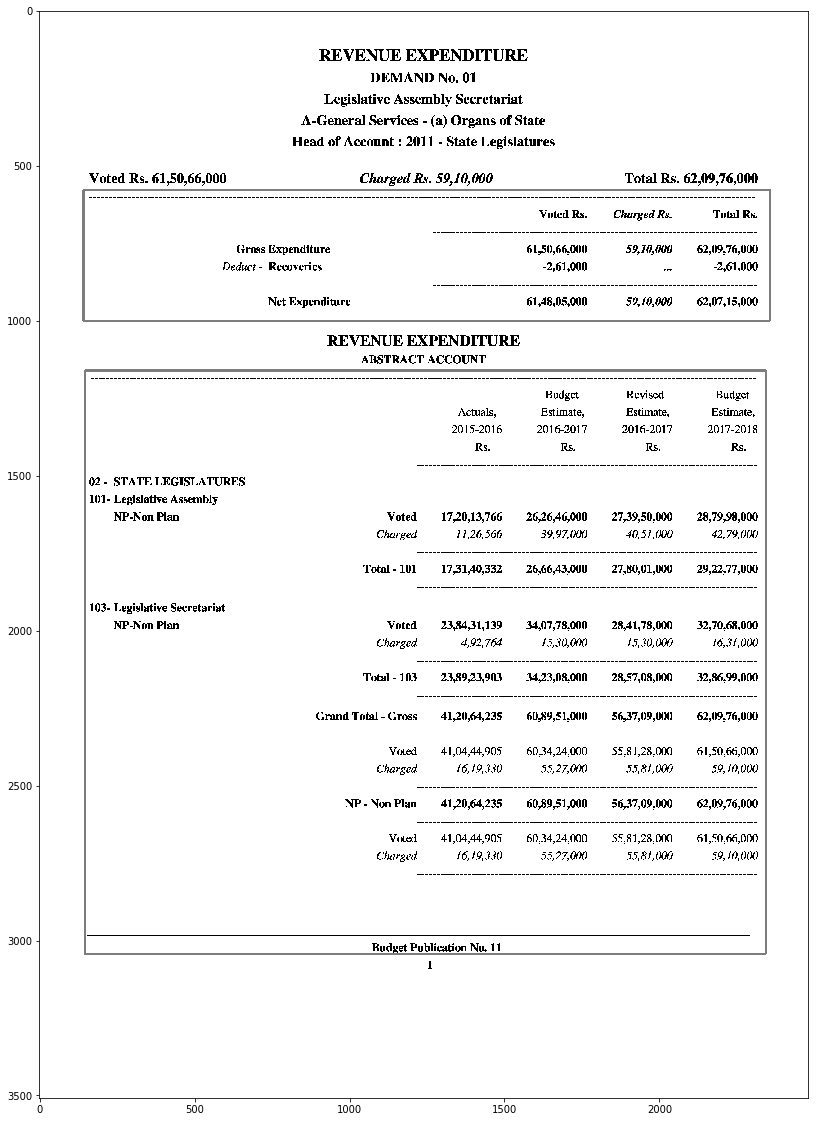

In [72]:
page2_tables = draw_table_bounding_box(img_page2, page2_label_stats)


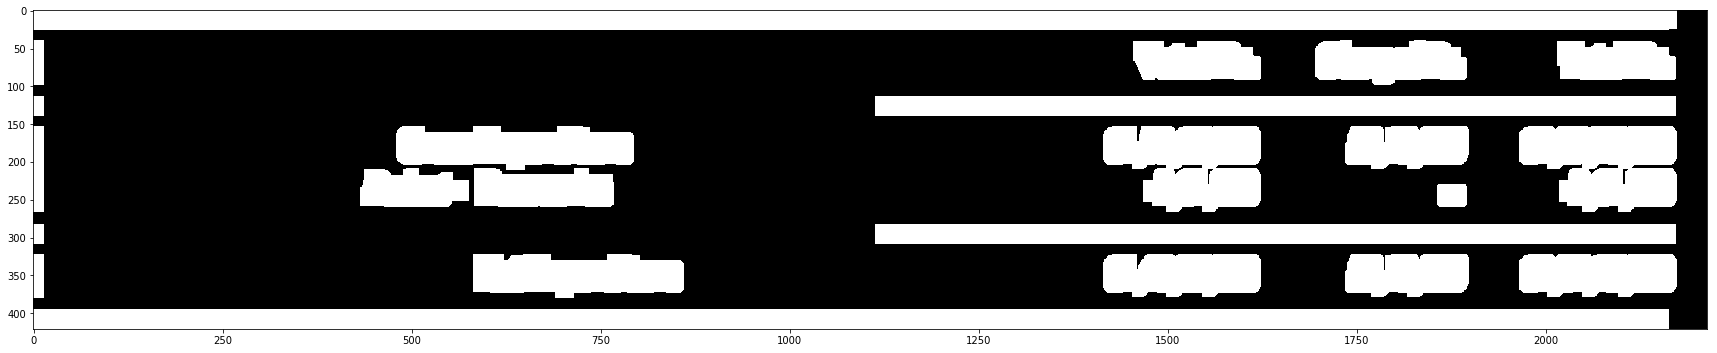

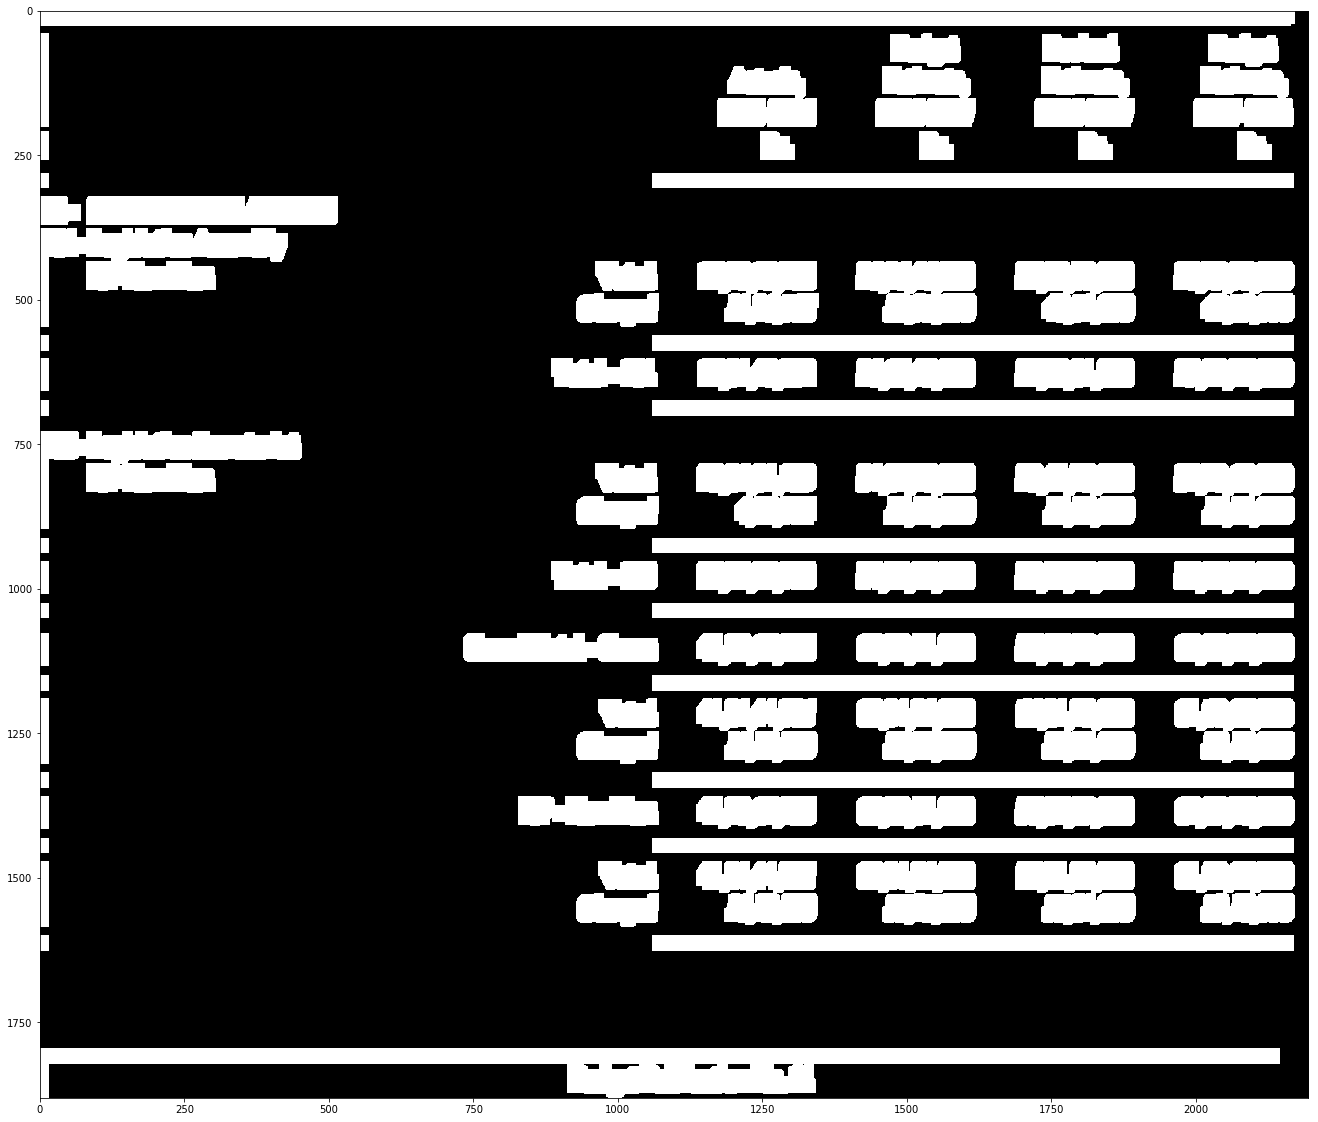

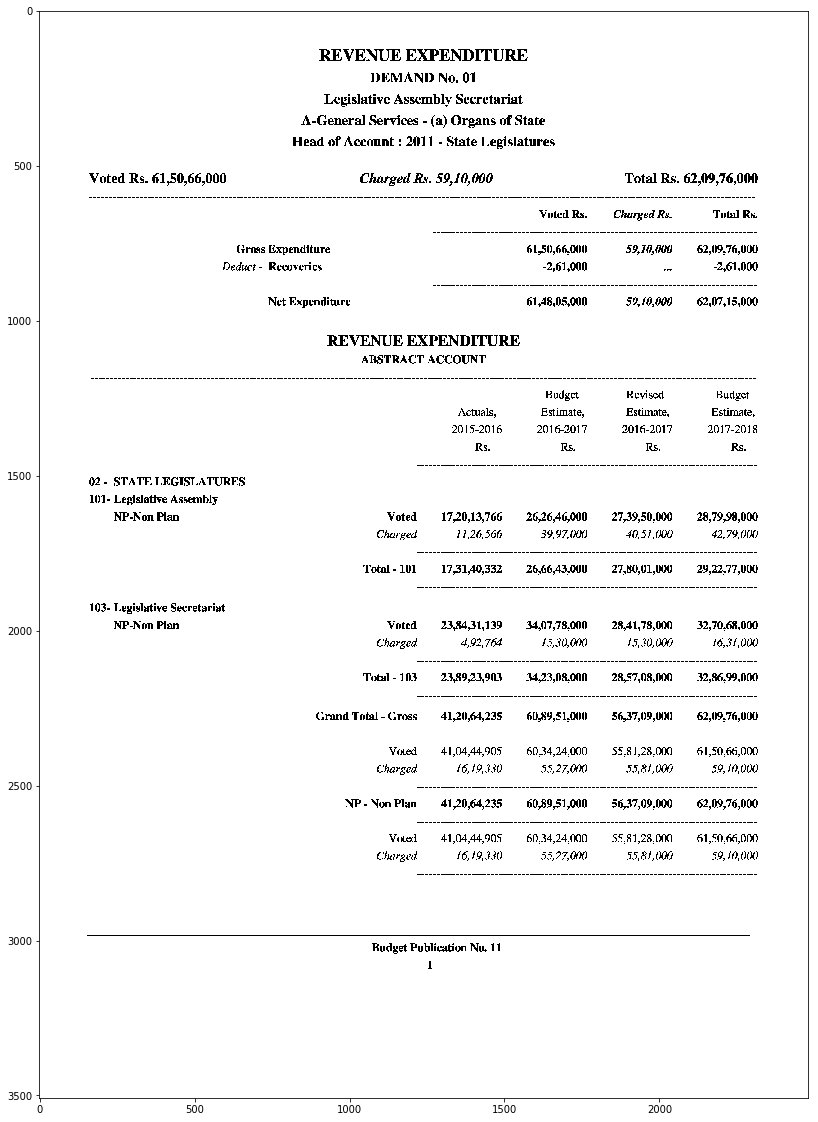

In [73]:
def get_text(page_num, pdf_file_name, x, y, w, h):
    command = 'pdftotext -enc UTF-8  -f {0} -l {0} -x {1} -y {2} -W {3} -H {4} "{5}" -'.format(page_num + 1,
                                                                                 int(x), 
                                                                                 int(y),
                                                                                 int(w),
                                                                                 int(h),
                                                                                 pdf_file_name)
    return subprocess.check_output(command, shell=True)

def get_text_data(row, page_num, pdf_file_path, horizontal_ratio, vertical_ratio):
    x = (row['left'] * horizontal_ratio)
    y = (row['top'] * vertical_ratio)
    width = (row['width'] * horizontal_ratio) + 5
    hieght = (row['height'] * vertical_ratio) + 5
    text = get_text(page_num, pdf_file_path, x, y, width, hieght)
    row['text'] = text.strip().replace('-','')
    row['text_length'] = len(row['text'])
    row['possible_row_merger'] = '\n' in row['text']
    text_matched = re.findall('[a-zA-Z_]+', row['text'])
    comma_sep_matcher = re.compile('^[1-9].(,[0-9]).*$')
    if comma_sep_matcher.match(row['text'].replace('\n', ' ')):
        row['comma_separated_numbers_present'] = True
    else:
        row['comma_separated_numbers_present'] = False
    if len(text_matched) > 0:
        row['is_text'] = True
    else:
        row['is_text'] = False
        
    try:
        row['number'] = int(row['text'].replace(',',''))
    except:
        row['number'] = None
    return row

def mark_number_cells(row):
    if row['comma_separated_numbers_present'] or row['is_text'] is False:
        row['label'] = 'cell_values'
    return row


def mark_text_cells(row, labels):
    '''
    Detect cells below, left and right. Based on these cells make guesses of labels.
    '''
    left, right = row['left'], row['right']
    top, bottom = row['top'], row['bottom']
    if row['label'] != 'cell_values':        
        if (labels[(labels.right.between(right - 10, right + 10)) & 
                     (labels.top > top) & (labels.label == 'cell_values')].shape[0] > 1):
            row['label'] = 'cell_header'
        elif (labels[(labels.top.between(top - 10, top + 10)) & 
                     (labels.left > left) & (labels.label == 'cell_values')].shape[0] > 1):
            row['label'] = 'cell_grouping'
        elif (labels[(labels.bottom.between(bottom - 10, bottom + 10)) & 
                     (labels.left > left) & (labels.label == 'cell_values')].shape[0] > 1):
            row['label'] = 'cell_grouping'
    return row
    

def get_possible_horizontal_lines(text_labels):
    possible_line_points = text_labels.bottom.value_counts()
    possible_line_points = possible_line_points[possible_line_points > 1]
    return possible_line_points.index


for table_bounds in page2_tables:
    table = rlsa_page2[table_bounds['top']:table_bounds['bottom'],
                        table_bounds['left']:table_bounds['right']]
    labels_in_table = page2_label_stats[(page2_label_stats.top > (table_bounds['top']  + 5)) & 
                                        (page2_label_stats.bottom < (table_bounds['bottom'] - 5)) &
                                        (page2_label_stats.left > (table_bounds['left'] - 5)) &
                                        (page2_label_stats.right < (table_bounds['right'] + 5))]
    labels_in_table = labels_in_table.apply(get_text_data, axis=1, args=[2, pdf_file_path,
                                                                         horizontal_ratio, vertical_ratio])
    text_labels = labels_in_table[labels_in_table.text_length > 0].apply(mark_number_cells, axis=1)
    text_labels = text_labels.apply(mark_text_cells, axis=1, args=[text_labels])
#     possible_horizontal_lines = get_possible_horizontal_lines(text_labels)
    plot_page(rlsa(img_page2[table_bounds['top']:table_bounds['bottom'],
                        table_bounds['left']:table_bounds['right']], (15, 25)))
plot_page(img_page2)


- Cross check if RLSA works better on zoomed images.
    Yes it Does perform differently, not to much with the thresholds we are using but there is certainly a difference.
   
Though We need to figure out which blocks to split, given the new combined information of text and position can we estimate which blocks should be combined or categorized also.

    - One basic rule of thumb for all documents, if number is involved and the block next to it is also a number   
      we can consider it as a cell.
    - If text is involved and it is positioned on the left side somewhere in the middle of the doc or towards   
      the end it would most probably be a cell.
    - For text that are in the top region, directly above cells can be considered as Headers.
    - Now the problem of merging and un merging of blocks generated needs to be Resolved, somehow.
    - Also another problem to ponder about, groupings or multi level structure - We have already tagged all 

In [74]:
text_labels


,area,bottom,centroid_x,centroid_y,comma_separated_numbers_present,height,is_text,label,left,number,pos,possible_row_merger,right,text,text_length,top,top_str,width
49,6212,1261,1675.519961,1229.796523,False,59,True,NaN,1613,NaN,49,False,1740,Budget,6,1202,1202,127
50,6578,1253,1943.899970,1228.496047,False,51,True,NaN,1875,NaN,50,False,2015,Revised,7,1202,1202,140
51,6254,1261,2225.048129,1229.807963,False,59,True,NaN,2162,NaN,51,False,2290,Budget,6,1202,1202,128
52,15406,1365,1401.864858,1316.907763,False,107,True,cell_header,1313,NaN,52,True,1492,"Actuals,\n20152016",17,1258,1258,179
53,16239,1365,1675.118111,1314.721535,False,107,True,cell_header,1587,NaN,53,True,1766,"Estimate,\n20162017",18,1258,1258,179
54,16225,1365,1950.056086,1314.757966,False,107,True,cell_header,1862,NaN,54,True,2041,"Estimate,\n20162017",18,1258,1258,179
55,16260,1365,2225.510578,1314.892005,False,107,True,cell_header,2137,NaN,55,True,2316,"Estimate,\n20172018",18,1258,1258,179
57,2913,1422,1417.744936,1398.115002,False,50,True,NaN,1388,NaN,57,False,1453,Rs.,3,1372,1372,65
58,2913,1422,1692.744936,1398.115002,False,50,True,NaN,1663,NaN,58,False,1728,Rs.,3,1372,1372,65
59,2942,1422,1967.092114,1398.202583,False,50,True,NaN,1937,NaN,59,False,2003,Rs.,3,1372,1372,66


There are flaws in the current approach as I am just checking adjacent points based on points, it should rather look for adjacent block with respect to direction and alignment alone, then utilize the information of that block to decide whether the current block is a cell, header or . That should make it more robust.


In [75]:
text_labels[['text', 'label']][pd.isnull(text_labels.label)]

,text,label
49,Budget,NaN
50,Revised,NaN
51,Budget,NaN
57,Rs.,NaN
58,Rs.,NaN
59,Rs.,NaN
60,Rs.,NaN
65,STATE LEGISLATURES,NaN
67,101 Legislative Assembly\nNPNon Plan,NaN
85,103 Legislative Secretariat\nNPNon Plan,NaN


### Intervention

Currently we are able to detect number based cells, with a minor issue of splitting them wherever required but for this we have already shown that this is detectable in the text also so its not all bad, Cell headers are also working and lowest level of grouping is also working decently and the rule intuitively seems general enough.

**What About Multi Level Groupings?**

This needs to be detected once we have all the other tags are done. So the idea is that we look for these groupings left to the lowest level of grouping, the assumption is that this grouping will always lie somewhere left to the lower level groupings and this can go upto n'th level though I don't think this would go more then 2 levels in any case because its harder to understand more deeper levels.

This idea, seems general enough and there would be some quirks there, I am pretty sure. But what about grouping labels like "State Legislatures" which itself doesn't have any corresponding value but it encapsulates other groups. Its more like a column name from what I understand though.

#### More Assumptions :- 

- Text that has a header above or below, its most probably part of the header.
- Text on left of `lower level grouping` would be its higher grouping.
- Text with no other labels in its path on the right would be a category of the grouping mentioned under it.
- Higher level groupings are always found on the left most areas.

#### Observations :-
- White space around each type also varies


In [76]:
def combine_headers(row, labels):
    left, top = row['left'], row['top']
    right, bottom = row['right'], row['bottom']
    # labels in a radius of 15
    x_pos_axis = labels[(labels.left.between(right - 10, right + 15)) &
                        (labels.label == 'cell_header')]
    x_neg_axis = labels[(labels.right.between(left - 15, left + 10)) &
                        (labels.label == 'cell_header')]
    y_pos_axis = labels[(labels.bottom.between(top - 20, top + 10)) &
                        (labels.label == 'cell_header')]
    y_neg_axis = labels[(labels.top.between(bottom - 10, bottom + 15)) &
                        (labels.label == 'cell_header')]

    if (len(x_pos_axis) + len(x_neg_axis) + len(y_pos_axis) + len(y_neg_axis)) > 0:
        if pd.isnull(row['label']):
            row['label'] = 'cell_header'
    return row

def find_higher_level_groupings(row, cell_grouping_height_range):
    bottom, label = row['bottom'], row['label']
    min_range, max_range = cell_grouping_height_range
    if (bottom > min_range) and (bottom < max_range) and (pd.isnull(label)):
        row['label'] = 'cell_higher_grouping'
    return row


In [77]:
text_labels.apply(combine_headers, axis=1, args=[text_labels])

,area,bottom,centroid_x,centroid_y,comma_separated_numbers_present,height,is_text,label,left,number,pos,possible_row_merger,right,text,text_length,top,top_str,width
49,6212,1261,1675.519961,1229.796523,False,59,True,cell_header,1613,NaN,49,False,1740,Budget,6,1202,1202,127
50,6578,1253,1943.899970,1228.496047,False,51,True,cell_header,1875,NaN,50,False,2015,Revised,7,1202,1202,140
51,6254,1261,2225.048129,1229.807963,False,59,True,cell_header,2162,NaN,51,False,2290,Budget,6,1202,1202,128
52,15406,1365,1401.864858,1316.907763,False,107,True,cell_header,1313,NaN,52,True,1492,"Actuals,\n20152016",17,1258,1258,179
53,16239,1365,1675.118111,1314.721535,False,107,True,cell_header,1587,NaN,53,True,1766,"Estimate,\n20162017",18,1258,1258,179
54,16225,1365,1950.056086,1314.757966,False,107,True,cell_header,1862,NaN,54,True,2041,"Estimate,\n20162017",18,1258,1258,179
55,16260,1365,2225.510578,1314.892005,False,107,True,cell_header,2137,NaN,55,True,2316,"Estimate,\n20172018",18,1258,1258,179
57,2913,1422,1417.744936,1398.115002,False,50,True,cell_header,1388,NaN,57,False,1453,Rs.,3,1372,1372,65
58,2913,1422,1692.744936,1398.115002,False,50,True,cell_header,1663,NaN,58,False,1728,Rs.,3,1372,1372,65
59,2942,1422,1967.092114,1398.202583,False,50,True,cell_header,1937,NaN,59,False,2003,Rs.,3,1372,1372,66


In [78]:
grouping_height_range = text_labels[text_labels.label == 'cell_grouping'].aggregate({'top': [min, max]}).values.flatten()
text_labels = text_labels.apply(combine_headers, axis=1, args=[text_labels]).apply(find_higher_level_groupings, axis=1, args=[grouping_height_range])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:3]
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:4]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:5]


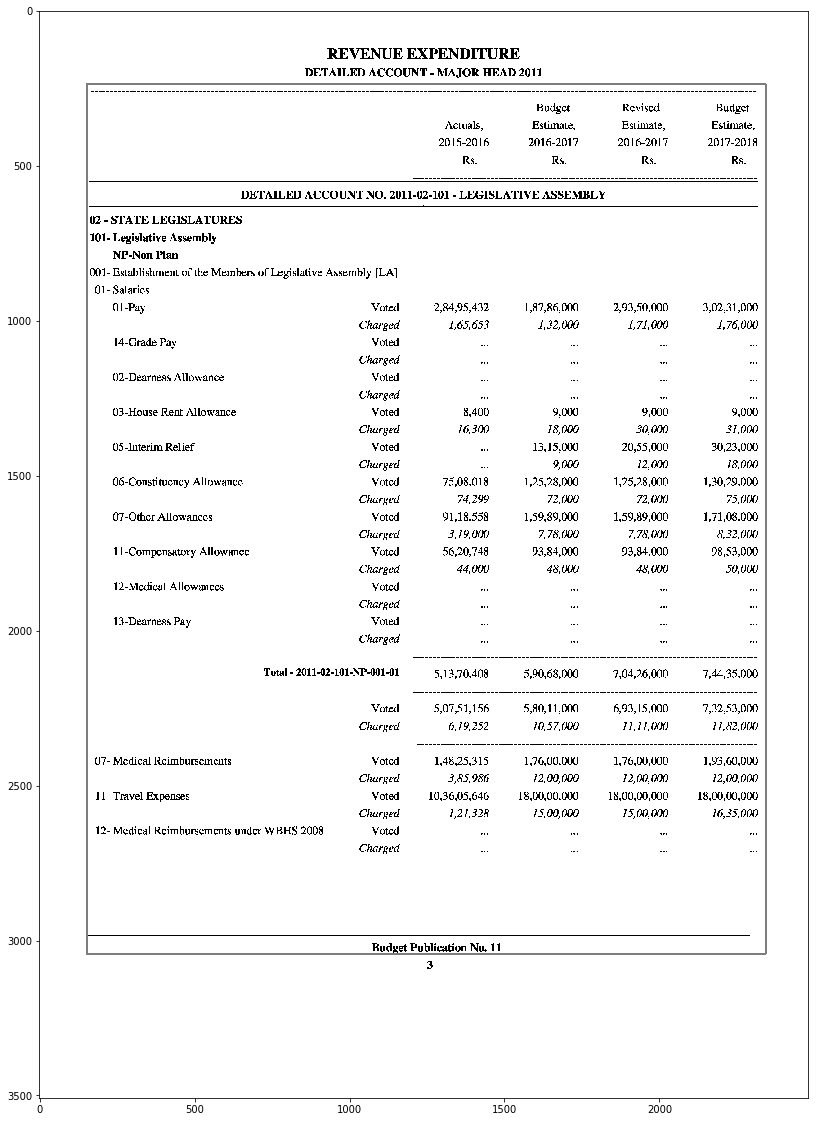

In [79]:
page4_tables = draw_table_bounding_box(img_page4, label_stats)
for table_bounds in page4_tables:
    table = rlsa_eroded_image_page4[table_bounds['top']:table_bounds['bottom'],
                        table_bounds['left']:table_bounds['right']]
    labels_in_table = label_stats[(label_stats.top > (table_bounds['top']  + 5)) & 
                                  (label_stats.bottom < (table_bounds['bottom'] - 5)) &
                                  (label_stats.left > (table_bounds['left'] - 5)) &
                                  (label_stats.right < (table_bounds['right'] + 5))]
    labels_in_table = labels_in_table.apply(get_text_data, axis=1, args=[4, pdf_file_path,
                                                                         horizontal_ratio, vertical_ratio])
    text_labels = labels_in_table[labels_in_table.text_length > 0].apply(mark_number_cells, axis=1)
    text_labels = text_labels.apply(mark_text_cells, axis=1, args=[text_labels])
    grouping_height_range = text_labels[text_labels.label == 'cell_grouping'].aggregate({'top': [min, max]}).values.flatten()
    text_labels = text_labels.apply(combine_headers, axis=1, args=[text_labels]).apply(find_higher_level_groupings, axis=1, args=[grouping_height_range])

In [80]:
text_labels[['text', 'label']].to_csv('page4_tags.csv')

there are some odd results, which makes the problem not easily solvable with just heuristics. Maybe we need to think about it from another angle, rather then trying to say what each block is why not focus on the important parts and let everything fall into place.. To expand on this, currently we are able to : -

    - Get headers.
    - Get Values
    
Based on these two lets draw the outline structure of the table with rows and columns, after that figure out in which row the other text columns lie, so instead of figuring out groupings, grouping levels, headers why not just `dumbify` the problem by trying to put each text column into some row.


Todo :- 

 - Implement the new idea
 - create a class/func that works end to end to test out other pages.

In [81]:
def extract_table_attributes(page_num, pdf):
    img_page = get_page_image_from_pdf(pdf, page_num, 'west_bengal_demand_1_5_page_1.png')
    image_height, image_width = img_page.shape
    horizontal_ratio = page_width / image_width
    vertical_ratio = page_height / image_height
    img_rlsa = rlsa(img_page, (20, 25))
    n_comp, labels, stats, centroids = cv2.connectedComponentsWithStats(img_rlsa)
    label_stats = get_label_stats(stats, centroids)
    label_stats['right'] = label_stats.left + label_stats.width
    label_stats['bottom'] = label_stats.top + label_stats.height
    tables = draw_table_bounding_box(img_page, label_stats)
    if len(tables) == 0: 
        print("No Tables found on page number {0}".format(page_num))
    all_text_labels = pd.DataFrame()
    index = 1
    for table_bounds in tables:
        table = img_rlsa[table_bounds['top']:table_bounds['bottom'],
                         table_bounds['left']:table_bounds['right']]
        labels_in_table = label_stats[(label_stats.top > (table_bounds['top']  + 5)) & 
                                      (label_stats.bottom < (table_bounds['bottom'] - 5)) &
                                      (label_stats.left > (table_bounds['left'] - 5)) &
                                      (label_stats.right < (table_bounds['right'] + 5))]
        labels_in_table = labels_in_table.apply(get_text_data, axis=1, args=[page_num, pdf_file_path,
                                                                             horizontal_ratio, vertical_ratio])
        text_labels = labels_in_table[labels_in_table.text_length > 0].apply(mark_number_cells, axis=1)
        text_labels = text_labels.apply(mark_text_cells, axis=1, args=[text_labels])
        grouping_height_range = text_labels[text_labels.label == 'cell_grouping'].aggregate({'top': [min, max]}).values.flatten()
        text_labels = text_labels.apply(combine_headers, axis=1, args=[text_labels]).apply(find_higher_level_groupings, axis=1, args=[grouping_height_range])
        text_labels['page_num'] = page_num
        text_labels['table_num'] = index
        index += 1
        all_text_labels = pd.concat([all_text_labels, text_labels])
    return all_text_labels

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:3]
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:4]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy [ipykernel_launcher.py:5]


,area,bottom,centroid_x,centroid_y,comma_separated_numbers_present,height,is_text,label,left,number,possible_row_merger,right,text,text_length,top,width,page_num,table_num
20,9843.0,679.0,1933.956416,648.331505,False,59.0,True,cell_header,1833.0,NaN,False,2039.0,Charged Rs.,11,620.0,206.0,2,1
21,8152.0,672.0,1678.513494,646.764475,False,51.0,True,cell_header,1593.0,NaN,False,1767.0,Voted Rs.,9,621.0,174.0,2,1
22,7692.0,672.0,2232.769501,646.766381,False,51.0,True,cell_header,2154.0,NaN,False,2316.0,Total Rs.,9,621.0,162.0,2,1
26,14864.0,791.0,775.951023,760.459634,False,58.0,True,cell_grouping,618.0,NaN,False,938.0,Gross Expenditure,17,733.0,320.0,2,1
27,19317.0,846.0,1671.421235,782.727390,True,113.0,False,cell_values,1553.0,NaN,True,1767.0,"61,50,66,000\n2,61,000",21,733.0,214.0,2,1
28,8747.0,790.0,1957.048588,759.089859,True,57.0,False,cell_values,1873.0,5910000.0,False,2042.0,"59,10,000",9,733.0,169.0,2,1
29,19346.0,846.0,2221.338261,782.709604,True,113.0,False,cell_values,2103.0,NaN,True,2317.0,"62,09,76,000\n2,61,000",21,733.0,214.0,2,1
30,6448.0,840.0,640.050093,816.051489,False,51.0,True,cell_grouping,570.0,NaN,False,719.0,Deduct,7,789.0,149.0,2,1
31,8624.0,840.0,813.858071,816.339402,False,51.0,True,cell_grouping,721.0,NaN,False,911.0,Recoveries,10,789.0,190.0,2,1
32,1311.0,840.0,2016.483600,824.467582,False,30.0,False,cell_values,1995.0,NaN,False,2039.0,...,3,810.0,44.0,2,1


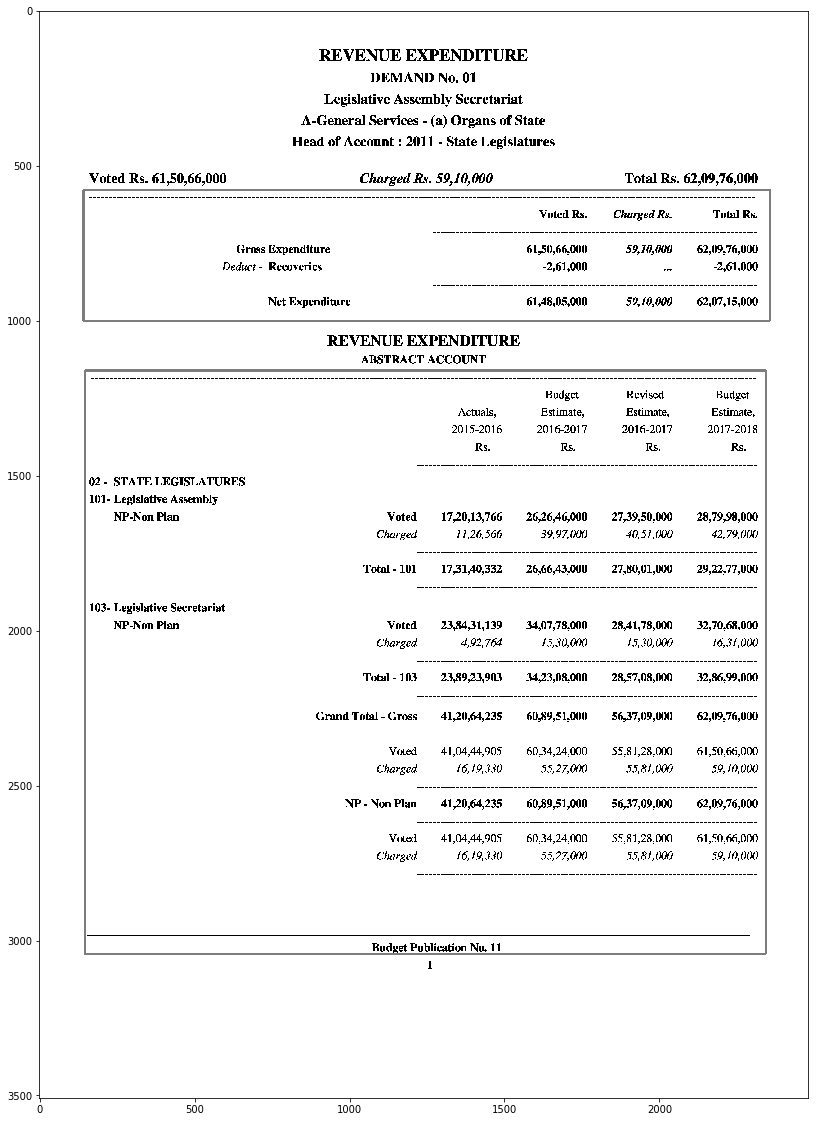

In [82]:
extract_table_attributes(2, pdf)

In [83]:
def find_rows(labels):
    """
    Figure out the points where rows start and end.
    
    1. Headers would be the starting point. Bottom of the headers
    2. Each cell value will be separated by a row. We need to handle where text is merged.
    """
    rows = []
    rows.extend(labels[labels['label'] == 'cell_header'].aggregate({'top': min, 'bottom': max}).values.flatten())
    rows.extend(labels[labels['label'] == 'cell_values']['bottom'].unique())
    filtered_rows = []
    for index, row_sep in enumerate(rows):
        if index > 0:
            last_row_sep = rows[index - 1]
            if row_sep > (last_row_sep + 20):
                filtered_rows.append(row_sep)
        else:
            filtered_rows.append(row_sep)
    return filtered_rows

def plot_horizontal_lines(line_ys, img, x_start, x_end):
    waste_copy2 = img.copy()
    for line_y in line_ys:
        line_starting_points = (int(x_start), int(line_y))
        line_stopping_points = (int(x_end), int(line_y))
        cv2.line(waste_copy2, line_starting_points, line_stopping_points, (125,255,0), 3)
    plot_page(waste_copy2)

def find_common_headers(labels):
    unmarked_headers = labels[(labels.label == 'cell_header') & (pd.isnull(labels.header_index))]
    if len(unmarked_headers) > 0:
        header = unmarked_headers[unmarked_headers.top == unmarked_headers.top.min()]
        labels.ix[((labels.label == 'cell_header') & 
                   (labels.left.between(header.left.iloc[0] - header.width.iloc[0], header.right.iloc[0])) &
                   (pd.isnull(labels.header_index))
                  ), 'header_index'] = header.pos.iloc[0]
        return find_common_headers(labels)
    return labels
    
def cleanse_labels(labels):
    """
    We need to clean up labels to transform them into csv's
    
    1. Combine Headers so that they don't end up in new lines.
    2. Split label blocks with 2 values combined 
    """
    processed_labels = pd.DataFrame()
    
    for index, row in labels.iterrows():
        splitted_row = []
        if row.possible_row_merger == True and  row.label != 'cell_header':
            for index, value in enumerate(row.text.split('\n')):
                new_row = {}
                for col in row.index:
                    new_row[col] = row[col]
                new_height = row.height // len(row.text.split('\n'))
                new_row['height'] = new_height
                new_row['top'] = row.top + (index * new_height)
                new_row['bottom'] = new_row['top'] + new_height
                new_row['text'] = value
                new_row['possible_row_merger'] = False
                splitted_row.append(new_row)
            processed_labels = processed_labels.append(splitted_row)
        else:
            processed_labels = processed_labels.append(row)
    return find_common_headers(processed_labels)

def mark_titles(labels):
    labels.ix[((labels.is_text == True) & 
               (labels.centroid_x.between(1200, 1300)) &
               (pd.isnull(labels.label))
              ), 'label'] = 'title'
    return labels

def mark_summary(row):
    if row['is_text'] == True:
        summaries = re.findall("^[A-z, a-z]*\sRs. [0-9|,]*$", row['text'])
        if len(summaries) > 0:
            row['label'] = 'cell_summary'
    return row


def filter_out_footer(labels):
    bottom_boundary = labels[labels.label == 'cell_values']['top'].max()
    return labels[labels.bottom < bottom_boundary]

def extract_table_attributes_row_based(page_num, pdf):
    img_page = get_page_image_from_pdf(pdf, page_num, 'west_bengal_demand_1_5_page_1.png')
    image_height, image_width = img_page.shape
    horizontal_ratio = page_width / image_width
    vertical_ratio = page_height / image_height
    img_rlsa = rlsa(img_page, (20, 25))
    n_comp, labels, stats, centroids = cv2.connectedComponentsWithStats(img_rlsa)
    label_stats = get_label_stats(stats, centroids)
    label_stats['right'] = label_stats.left + label_stats.width
    label_stats['bottom'] = label_stats.top + label_stats.height
    label_stats = label_stats.apply(get_text_data, axis=1, args=[page_num, pdf_file_path,
                                                                 horizontal_ratio, vertical_ratio])
#     label_stats = mark_titles(label_stats)
    tables = draw_table_bounding_box(img_page, label_stats)
    if len(tables) == 0:
        print("No Tables found on page number {0}".format(page_num))
    all_text_labels = pd.DataFrame()
    index = 1
    for table_bounds in tables:
        table = img_rlsa[table_bounds['top']:table_bounds['bottom'],
                         table_bounds['left']:table_bounds['right']]
        labels_in_table = label_stats[(label_stats.top > (table_bounds['top']  + 5)) &
                                      (label_stats.bottom < (table_bounds['bottom'] - 5)) &
                                      (label_stats.left > (table_bounds['left'] - 5)) &
                                      (label_stats.right < (table_bounds['right'] + 5))]
#         labels_in_table = labels_in_table.apply(get_text_data, axis=1, args=[page_num, pdf_file_path,
#                                                                              horizontal_ratio, vertical_ratio])
        text_labels = labels_in_table[labels_in_table.text_length > 0].apply(mark_number_cells, axis=1)
        text_labels = text_labels.apply(mark_text_cells, axis=1, args=[text_labels])
        grouping_height_range = text_labels[text_labels.label == 'cell_grouping'].aggregate({'top': [min, max]}).values.flatten()
        text_labels = text_labels.apply(combine_headers, axis=1, args=[text_labels]).apply(find_higher_level_groupings, axis=1, args=[grouping_height_range])
        text_labels['header_index'] = None
        text_labels['pos'] = text_labels.index
        text_labels = cleanse_labels(text_labels)
        text_labels['page_num'] = page_num
        text_labels['table_num'] = index
        rows = find_rows(text_labels)
        row_ranges = zip(rows, rows[1:])
        for start, end in row_ranges:
            print(text_labels[text_labels.top.between(start, end - 5)].text.values)
        plot_horizontal_lines(rows, img_page, 150, 2350)
        index += 1
        all_text_labels = pd.concat([all_text_labels, text_labels])
        break
    return all_text_labels

In [84]:
extract_table_attributes_row_based(2, pdf)

.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated [ipykernel_launcher.py:72]


AttributeError: 'DataFrame' object has no attribute 'label'

In [ ]:
glabel_stats

In [ ]:
extract_table_attributes_row_based(22, pdf)

In [ ]:
extract_table_attributes_row_based(30, pdf)

There is a lot of overlap in the rows and it seems to work well in a couple of pages. Another observation page no 22 has a table separation without any vertical lines, there are two observations on that front :-

    - Threre is a huge text block between them
    - There is a lot of space between the tables due to the heading
    
    
Todo

    - filtering out overlapping or close by lines -------x
    - do the following label processing : - 
        - separate out labels where `\n` new line character is present into two labels -------x
        - merge all header labels into one ---------x
    - a better table detection method.
    - a process to convert the information into a consumable csv.
    - Detect Titles and store the tables with title names
    

In [ ]:
label_stats

### Figuring out title detection

There are a couple of assumptions that we can use to detect the title text : -

    - Its usually center aligned
    - It would be bigger then the other text

In [85]:
img_page = get_page_image_from_pdf(pdf, 2, 'west_bengal_demand_1_5_page_1.png')
image_height, image_width = img_page.shape
horizontal_ratio = page_width / image_width
vertical_ratio = page_height / image_height
img_rlsa = rlsa(img_page, (20, 25))
n_comp, labels, stats, centroids = cv2.connectedComponentsWithStats(img_rlsa)
label_stats = get_label_stats(stats, centroids)
label_stats['right'] = label_stats.left + label_stats.width
label_stats['bottom'] = label_stats.top + label_stats.height

In [86]:
img_page.shape

(3508, 2479)

In [87]:
label_stats_with_text = label_stats.apply(get_text_data, axis=1, args=[2, pdf_file_path, horizontal_ratio, vertical_ratio])

In [88]:
label_stats_with_text[label_stats_with_text.is_text == True]

,left,top,width,height,area,centroid_x,centroid_y,right,bottom,text,text_length,possible_row_merger,comma_separated_numbers_present,is_text,number
4,885.0,103.0,690.0,62.0,42076.0,1229.127793,133.112392,1575.0,165.0,REVENUE EXPENDITURE,19,False,False,True,NaN
6,1049.0,177.0,360.0,57.0,19420.0,1225.853708,205.540783,1409.0,234.0,DEMAND No. 01,13,False,False,True,NaN
8,901.0,246.0,658.0,66.0,34215.0,1225.751308,277.009908,1559.0,312.0,Legislative Assembly Secretariat,32,False,False,True,NaN
10,827.0,315.0,805.0,66.0,41069.0,1232.540627,346.063040,1632.0,381.0,AGeneral Services (a) Organs of State,38,False,False,True,NaN
12,798.0,383.0,864.0,66.0,44366.0,1228.446445,413.491277,1662.0,449.0,Head of Account : 2011 State Legislatures,42,False,False,True,NaN
14,142.0,502.0,462.0,65.0,25409.0,379.711559,531.492739,604.0,567.0,"Voted Rs. 61,50,66,000",22,False,False,True,NaN
15,1016.0,502.0,446.0,66.0,24421.0,1242.827566,532.310348,1462.0,568.0,"Charged Rs. 59,10,000",21,False,False,True,NaN
16,1869.0,502.0,448.0,65.0,24894.0,2098.311762,531.411304,2317.0,567.0,"Total Rs. 62,09,76,000",22,False,False,True,NaN
20,1833.0,620.0,206.0,59.0,9843.0,1933.956416,648.331505,2039.0,679.0,Charged Rs.,11,False,False,True,NaN
21,1593.0,621.0,174.0,51.0,8152.0,1678.513494,646.764475,1767.0,672.0,Voted Rs.,9,False,False,True,NaN


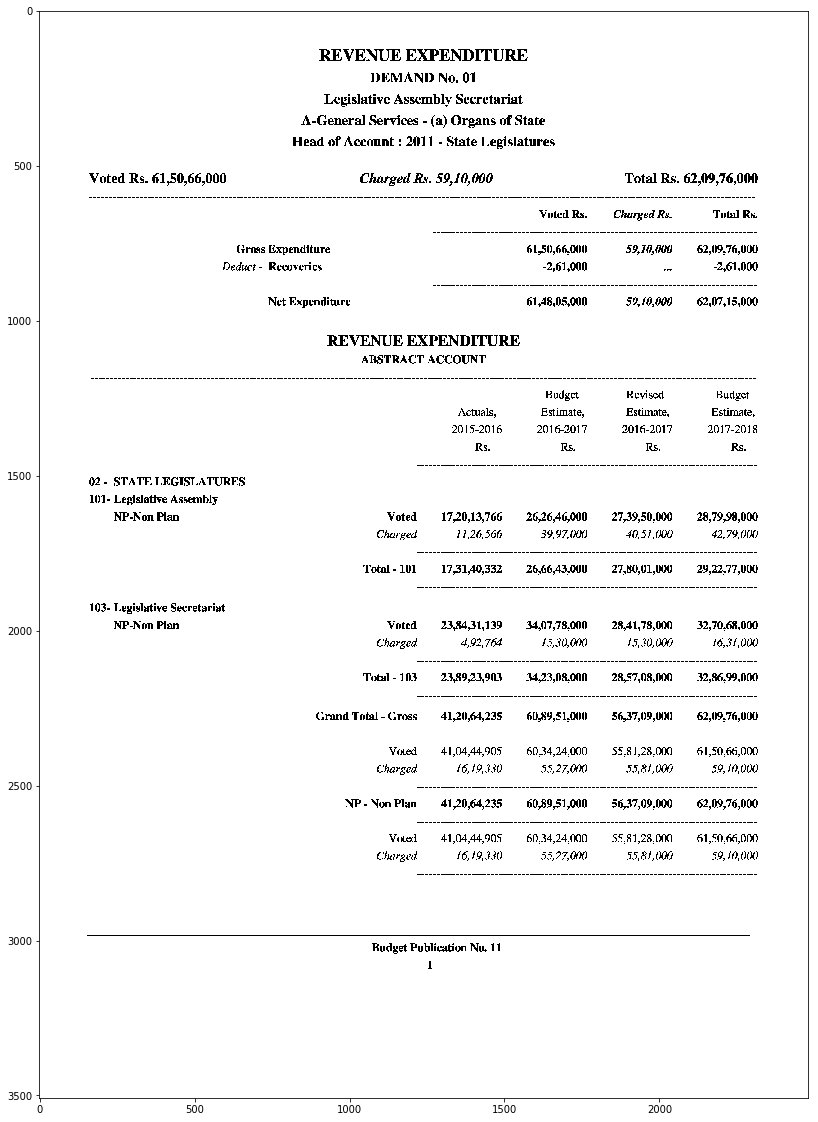

In [89]:
plot_page(img_page)

In [90]:
label_stats_with_text[(label_stats_with_text.is_text == True) & (label_stats_with_text.centroid_x.between(1200, 1300))]

,left,top,width,height,area,centroid_x,centroid_y,right,bottom,text,text_length,possible_row_merger,comma_separated_numbers_present,is_text,number
4,885.0,103.0,690.0,62.0,42076.0,1229.127793,133.112392,1575.0,165.0,REVENUE EXPENDITURE,19,False,False,True,NaN
6,1049.0,177.0,360.0,57.0,19420.0,1225.853708,205.540783,1409.0,234.0,DEMAND No. 01,13,False,False,True,NaN
8,901.0,246.0,658.0,66.0,34215.0,1225.751308,277.009908,1559.0,312.0,Legislative Assembly Secretariat,32,False,False,True,NaN
10,827.0,315.0,805.0,66.0,41069.0,1232.540627,346.063040,1632.0,381.0,AGeneral Services (a) Organs of State,38,False,False,True,NaN
12,798.0,383.0,864.0,66.0,44366.0,1228.446445,413.491277,1662.0,449.0,Head of Account : 2011 State Legislatures,42,False,False,True,NaN
15,1016.0,502.0,446.0,66.0,24421.0,1242.827566,532.310348,1462.0,568.0,"Charged Rs. 59,10,000",21,False,False,True,NaN
43,911.0,1025.0,638.0,59.0,37051.0,1229.191007,1053.613938,1549.0,1084.0,REVENUE EXPENDITURE,19,False,False,True,NaN
45,1019.0,1089.0,421.0,51.0,20972.0,1230.401821,1113.837784,1440.0,1140.0,ABSTRACT ACCOUNT,16,False,False,True,NaN
137,135.0,2957.0,2157.0,86.0,81564.0,1227.328956,2981.084621,2292.0,3043.0,______________________________________________...,140,True,False,True,NaN


In [91]:
label_stats_with_text = label_stats_with_text[label_stats_with_text.text_length > 0].apply(mark_number_cells, axis=1)
label_stats_with_text = label_stats_with_text.apply(mark_text_cells, axis=1, args=[label_stats_with_text])
label_stats_with_text = label_stats_with_text.apply(combine_headers, axis=1, args=[label_stats_with_text])
label_stats_with_text = label_stats_with_text.apply(mark_summary, axis=1)
label_stats_with_text = filter_out_footer(label_stats_with_text)

In [92]:
label_stats_with_text

,area,bottom,centroid_x,centroid_y,comma_separated_numbers_present,height,is_text,label,left,number,possible_row_merger,right,text,text_length,top,width
4,42076.0,165.0,1229.127793,133.112392,False,62.0,True,cell_header,885.0,NaN,False,1575.0,REVENUE EXPENDITURE,19,103.0,690.0
6,19420.0,234.0,1225.853708,205.540783,False,57.0,True,NaN,1049.0,NaN,False,1409.0,DEMAND No. 01,13,177.0,360.0
8,34215.0,312.0,1225.751308,277.009908,False,66.0,True,NaN,901.0,NaN,False,1559.0,Legislative Assembly Secretariat,32,246.0,658.0
10,41069.0,381.0,1232.540627,346.063040,False,66.0,True,NaN,827.0,NaN,False,1632.0,AGeneral Services (a) Organs of State,38,315.0,805.0
12,44366.0,449.0,1228.446445,413.491277,False,66.0,True,NaN,798.0,NaN,False,1662.0,Head of Account : 2011 State Legislatures,42,383.0,864.0
14,25409.0,567.0,379.711559,531.492739,False,65.0,True,cell_summary,142.0,NaN,False,604.0,"Voted Rs. 61,50,66,000",22,502.0,462.0
15,24421.0,568.0,1242.827566,532.310348,False,66.0,True,cell_summary,1016.0,NaN,False,1462.0,"Charged Rs. 59,10,000",21,502.0,446.0
16,24894.0,567.0,2098.311762,531.411304,False,65.0,True,cell_summary,1869.0,NaN,False,2317.0,"Total Rs. 62,09,76,000",22,502.0,448.0
20,9843.0,679.0,1933.956416,648.331505,False,59.0,True,cell_header,1833.0,NaN,False,2039.0,Charged Rs.,11,620.0,206.0
21,8152.0,672.0,1678.513494,646.764475,False,51.0,True,cell_header,1593.0,NaN,False,1767.0,Voted Rs.,9,621.0,174.0


In [93]:

label_stats_with_text[['text', 'label']].values

array([['REVENUE EXPENDITURE', 'cell_header'],
       ['DEMAND No. 01', nan],
       ['Legislative Assembly Secretariat', nan],
       ['AGeneral Services  (a) Organs of State', nan],
       ['Head of Account : 2011  State Legislatures', nan],
       ['Voted Rs. 61,50,66,000', 'cell_summary'],
       ['Charged Rs. 59,10,000', 'cell_summary'],
       ['Total Rs. 62,09,76,000', 'cell_summary'],
       ['Charged Rs.', 'cell_header'],
       ['Voted Rs.', 'cell_header'],
       ['Total Rs.', 'cell_header'],
       ['Gross Expenditure', 'cell_grouping'],
       ['61,50,66,000\n2,61,000', 'cell_values'],
       ['59,10,000', 'cell_values'],
       ['62,09,76,000\n2,61,000', 'cell_values'],
       ['Deduct ', 'cell_grouping'],
       ['Recoveries', 'cell_grouping'],
       ['...', 'cell_values'],
       ['Net Expenditure', 'cell_grouping'],
       ['61,48,05,000', 'cell_values'],
       ['59,10,000', 'cell_values'],
       ['62,07,15,000', 'cell_values'],
       ['REVENUE EXPENDITURE', nan],


In [94]:
label_stats_with_text[label_stats_with_text.label == 'cell_values']['top'].max()

2633.0

In [95]:
label_stats_with_text[label_stats_with_text.bottom < 3041].shape

(83, 16)

### Using titles to separate out tables

We need to figure out if there exists two groups of titles

In [96]:
titles = label_stats_with_text[label_stats_with_text.label == 'title']
titles

,area,bottom,centroid_x,centroid_y,comma_separated_numbers_present,height,is_text,label,left,number,possible_row_merger,right,text,text_length,top,width


In [97]:
titles['next_diff'] = titles.top - titles.top.shift(1)
titles[titles.next_diff > titles.next_diff.mean()]

,area,bottom,centroid_x,centroid_y,comma_separated_numbers_present,height,is_text,label,left,number,possible_row_merger,right,text,text_length,top,width,next_diff


In [98]:
label_stats_with_text[label_stats_with_text.top < 1025]

,area,bottom,centroid_x,centroid_y,comma_separated_numbers_present,height,is_text,label,left,number,possible_row_merger,right,text,text_length,top,width
4,42076.0,165.0,1229.127793,133.112392,False,62.0,True,cell_header,885.0,NaN,False,1575.0,REVENUE EXPENDITURE,19,103.0,690.0
6,19420.0,234.0,1225.853708,205.540783,False,57.0,True,NaN,1049.0,NaN,False,1409.0,DEMAND No. 01,13,177.0,360.0
8,34215.0,312.0,1225.751308,277.009908,False,66.0,True,NaN,901.0,NaN,False,1559.0,Legislative Assembly Secretariat,32,246.0,658.0
10,41069.0,381.0,1232.540627,346.063040,False,66.0,True,NaN,827.0,NaN,False,1632.0,AGeneral Services (a) Organs of State,38,315.0,805.0
12,44366.0,449.0,1228.446445,413.491277,False,66.0,True,NaN,798.0,NaN,False,1662.0,Head of Account : 2011 State Legislatures,42,383.0,864.0
14,25409.0,567.0,379.711559,531.492739,False,65.0,True,cell_summary,142.0,NaN,False,604.0,"Voted Rs. 61,50,66,000",22,502.0,462.0
15,24421.0,568.0,1242.827566,532.310348,False,66.0,True,cell_summary,1016.0,NaN,False,1462.0,"Charged Rs. 59,10,000",21,502.0,446.0
16,24894.0,567.0,2098.311762,531.411304,False,65.0,True,cell_summary,1869.0,NaN,False,2317.0,"Total Rs. 62,09,76,000",22,502.0,448.0
20,9843.0,679.0,1933.956416,648.331505,False,59.0,True,cell_header,1833.0,NaN,False,2039.0,Charged Rs.,11,620.0,206.0
21,8152.0,672.0,1678.513494,646.764475,False,51.0,True,cell_header,1593.0,NaN,False,1767.0,Voted Rs.,9,621.0,174.0


In [99]:
label_stats_with_text[label_stats_with_text.top >= 1025]

,area,bottom,centroid_x,centroid_y,comma_separated_numbers_present,height,is_text,label,left,number,possible_row_merger,right,text,text_length,top,width
43,37051.0,1084.0,1229.191007,1053.613938,False,59.0,True,NaN,911.0,NaN,False,1549.0,REVENUE EXPENDITURE,19,1025.0,638.0
45,20972.0,1140.0,1230.401821,1113.837784,False,51.0,True,NaN,1019.0,NaN,False,1440.0,ABSTRACT ACCOUNT,16,1089.0,421.0
49,6212.0,1261.0,1675.519961,1229.796523,False,59.0,True,cell_header,1613.0,NaN,False,1740.0,Budget,6,1202.0,127.0
50,6578.0,1253.0,1943.899970,1228.496047,False,51.0,True,cell_header,1875.0,NaN,False,2015.0,Revised,7,1202.0,140.0
51,6254.0,1261.0,2225.048129,1229.807963,False,59.0,True,cell_header,2162.0,NaN,False,2290.0,Budget,6,1202.0,128.0
52,15406.0,1365.0,1401.864858,1316.907763,False,107.0,True,cell_header,1313.0,NaN,True,1492.0,"Actuals,\n20152016",17,1258.0,179.0
53,16239.0,1365.0,1675.118111,1314.721535,False,107.0,True,cell_header,1587.0,NaN,True,1766.0,"Estimate,\n20162017",18,1258.0,179.0
54,16225.0,1365.0,1950.056086,1314.757966,False,107.0,True,cell_header,1862.0,NaN,True,2041.0,"Estimate,\n20162017",18,1258.0,179.0
55,16260.0,1365.0,2225.510578,1314.892005,False,107.0,True,cell_header,2137.0,NaN,True,2316.0,"Estimate,\n20172018",18,1258.0,179.0
57,2913.0,1422.0,1417.744936,1398.115002,False,50.0,True,cell_header,1388.0,NaN,False,1453.0,Rs.,3,1372.0,65.0
